In [7]:
import catboost as cb

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
import missingno
from lightgbm import LGBMRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV

In [34]:
df =pd.read_excel("/content/Saha_et_al_2020_ERL_Data.xlsx",sheet_name ='Data')

In [35]:
df.describe()

,Year,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
count,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2194.000000,2170.000000,2216.000000,2246.000000,2246.000000,2246.000000
mean,2011.925200,7.468610,142.994212,5.219839,19.245273,12.408699,195.321015,198.898041,0.531047,11.451364,24.997063,134.425163,462.686739,1.901503
std,3.617418,28.488257,56.130412,10.064123,23.723416,9.490152,144.915448,142.907436,0.171868,13.214895,24.941785,79.564891,219.451957,1.132896
min,2002.000000,-7.415297,0.000000,0.000000,0.000000,-20.700000,1.000000,0.000000,0.024388,1.383393,0.370070,62.500000,55.000000,1.174072
25%,2011.000000,0.504316,135.000000,0.000000,3.560000,5.940000,73.250000,75.000000,0.390203,5.290323,10.184722,62.500000,418.833333,1.174072
50%,2013.000000,1.972058,170.000000,0.510000,11.930000,14.490000,160.000000,172.000000,0.553853,9.081282,19.795863,128.333333,491.666667,1.186800
75%,2014.000000,5.187618,170.000000,6.000000,27.000000,20.070000,308.750000,320.000000,0.680321,12.140325,27.085459,183.250000,637.500000,1.823200
max,2017.000000,593.072000,213.000000,95.250000,260.090000,30.700000,718.000000,678.000000,0.912113,228.525000,238.920000,280.000000,637.500000,4.500000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2246 non-null   datetime64[ns]
 1   Year         2246 non-null   int64         
 2   Experiment   2246 non-null   object        
 3   DataUse      2246 non-null   object        
 4   Replication  2246 non-null   object        
 5   Month        2246 non-null   object        
 6   Vegetation   2246 non-null   object        
 7   VegType      2246 non-null   object        
 8   N2O          2246 non-null   float64       
 9   N_rate       2246 non-null   int64         
 10  PP2          2246 non-null   float64       
 11  PP7          2246 non-null   float64       
 12  AirT         2246 non-null   float64       
 13  DAF_TD       2246 non-null   int64         
 14  DAF_SD       2246 non-null   int64         
 15  WFPS25cm     2194 non-null   float64       
 16  NH4   

In [ ]:
df.shape

(2246, 21)

In [ ]:
df.isnull().sum()

Date            0
Year            0
Experiment      0
DataUse         0
Replication     0
Month           0
Vegetation      0
VegType         0
N2O             0
N_rate          0
PP2             0
PP7             0
AirT            0
DAF_TD          0
DAF_SD          0
WFPS25cm       52
NH4            76
NO3            30
Clay            0
Sand            0
SOM             0
dtype: int64

“Machine learning improves predictions of agricultural nitrous oxide (N2O) emissions from intensively managed cropping systems”
 

Year: Calendar year

Experiment: Data from three long-term experiments were used in this analysis. The "BCSE_KBS" and "MCSE-T2" are located at the
W. K. Kellogg Biological Station in southwest Michigan, USA; the "Arlington WI" is located in Wisconsin, USA.

DataUse: To assign data to be used for model training and testing

Replication: Experimental replications

Month: Month of the year

Vegetation: The "BCSE_KBS" and "Arlington WI" include data from continuous no-till corn (Zea mays L.). 
    The "MCSE-T2" experiment is a three year no-till corn-soybean (Glycine max L.)-wheat (Triticum aestivum L.) rotation. 
    GLYMX and TRIAE in "MCSE-T2" represent soybean and wheat, respectively.

VegType: Annual/perennial

N2O: Daily average N2O flux (g N2O-N ha-1d-1)

N_rate: N fertilization rate (kg N ha-1)

PP2: Cumulative precipitation in the last two days before gas sampling (mm)

PP7: Cumulative precipitation in the last week before gas sampling (mm)

AirT: Daily average air temperature (°C)

DAF_TD: Days after top-dressed N fertilizer application (days)

DAF_SD: Days after side-dressed N fertilizer application (days)

WFPS25cm: Water-filled pore space in the top 25-cm soil layer (fraction)

NH4: NH4-N content in the top 25-cm soil layer (kg ha-1)

NO3: NO3-N content in the top 25-cm soil layer (kg ha-1)

Clay: Clay concentration in the top 25-cmsoil layer (g kg-1)

SOM: soil organic matter concentration (%)


<h2>Univariate Analysis</h2>

In [ ]:
df_int = df.select_dtypes(include = ["int64","float64"])

In [ ]:
df_int

,Year,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
0,2012,3.896742,170,0.00,0.00,-2.00,276,241,0.666508,11.046340,22.940812,62.500000,637.500000,1.174072
1,2012,2.190218,170,0.00,0.00,-2.40,277,242,0.640608,11.008087,22.959578,62.500000,637.500000,1.174072
2,2012,3.542594,170,3.30,8.64,0.30,285,250,0.728085,10.831669,23.221928,62.500000,637.500000,1.174072
3,2012,3.342870,170,0.00,8.13,-3.80,286,251,0.686872,10.849792,23.271978,62.500000,637.500000,1.174072
4,2012,2.947778,170,1.02,8.39,17.60,312,277,0.716221,10.204748,24.206855,62.500000,637.500000,1.174072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,2013,1.640000,91,3.81,8.13,10.81,167,167,0.390203,17.061793,5.803681,128.333333,491.666667,1.806000
2242,2013,0.990000,91,0.00,8.13,5.64,197,197,0.317040,5.624730,5.429873,162.500000,490.375000,1.496400
2243,2013,-0.200000,91,0.00,8.13,5.64,197,197,0.341428,3.504328,7.239000,183.250000,432.875000,1.186800
2244,2013,0.300000,91,0.00,8.13,5.64,197,197,0.365815,3.636931,8.434294,169.833333,418.833333,1.823200


<h3>Checking the distribution of numerical data</h3>

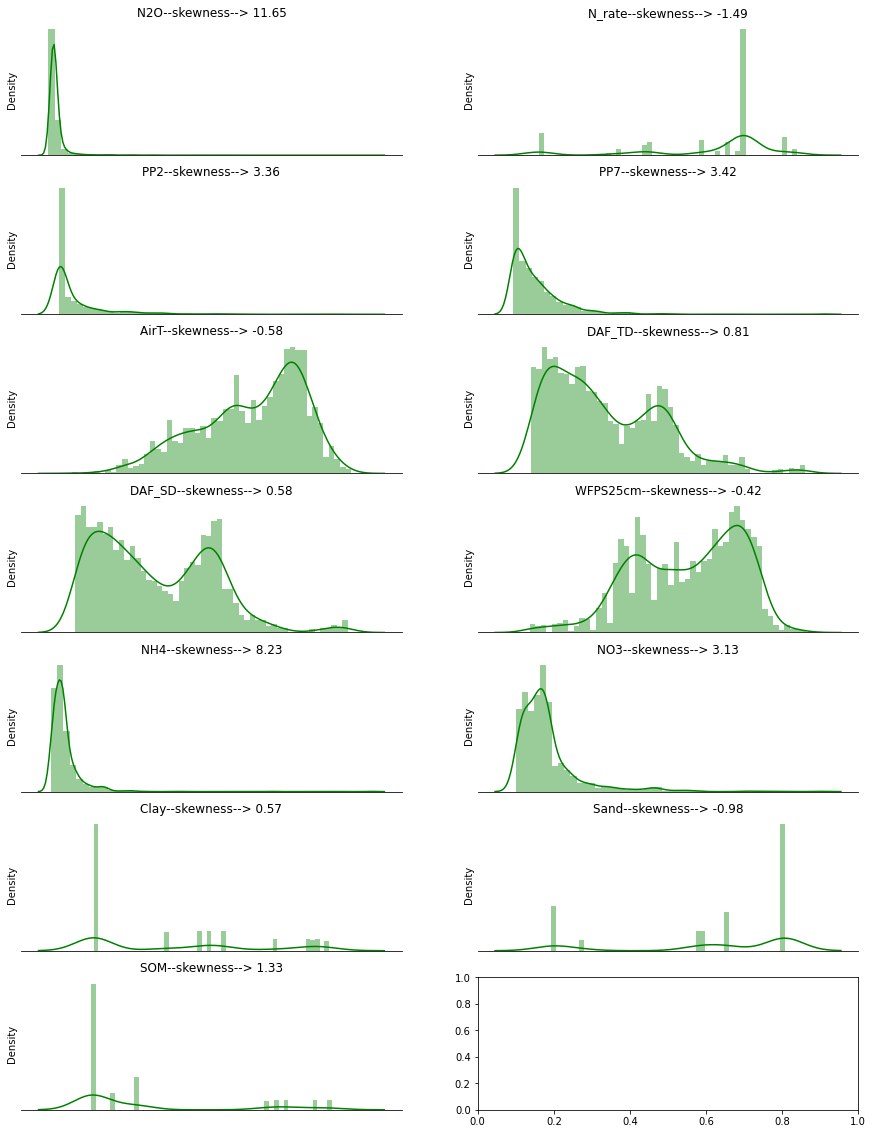

In [ ]:
fig, axes = plt.subplots(7,2,figsize=(15,20))
for x,ax in zip(df_int.columns[1:],axes.flatten()):
    sns.distplot(df_int[x],ax = ax,color ='g',bins= 50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_title(f'{x}--skewness--> {np.round(df_int[x].skew(),2)}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

<li>If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. </li>
<li>If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed.</li> 
<li>If the skewness is less than -1 or greater than 1, the data are highly skewed.</li>

<h3>We need to normalize all the data ,since all have highly skewed </li>

# Outliers

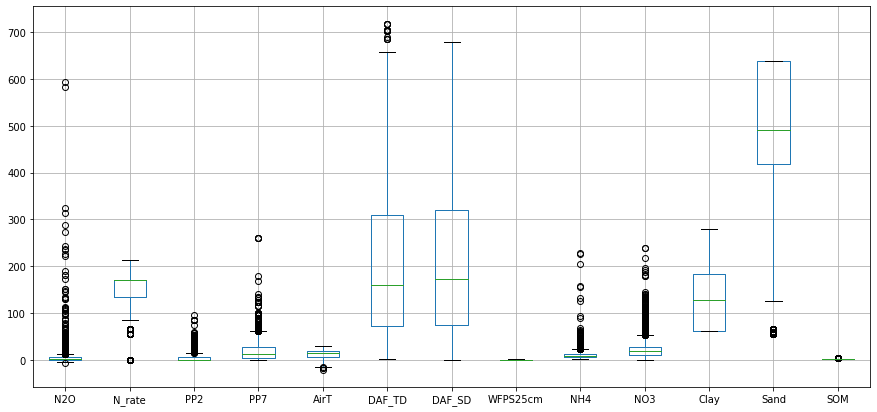

In [ ]:
df_int.iloc[:,1:].boxplot(figsize =(15,7))

<li>N20 target have high outliers</li>
<li>followed by Nh4 and N03</li>


Categorical COlumns

In [ ]:
df_obj = df.select_dtypes(include=object)
df_obj.columns[df_obj.columns!='Month']

Index(['Experiment', 'DataUse', 'Replication', 'Vegetation', 'VegType'], dtype='object')

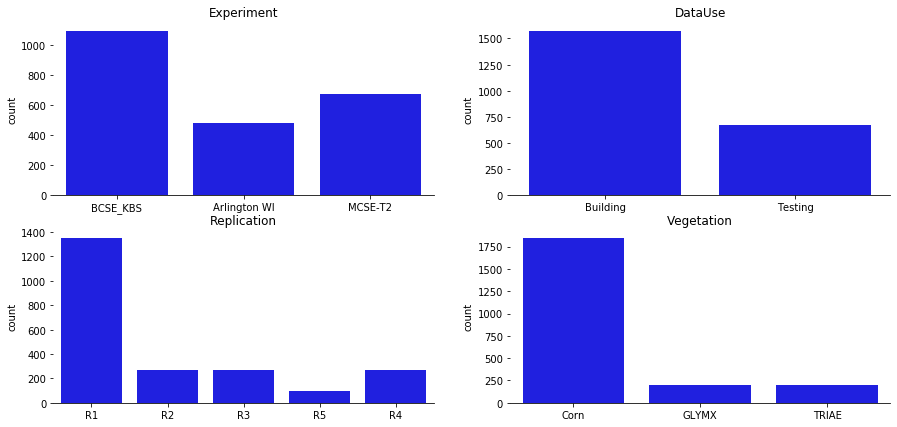

In [ ]:
fig,axes =plt.subplots(2,2,figsize=(15,7))
for x,ax in zip(df_obj.columns[df_obj.columns!='Month'][:-1],axes.flatten()):
    sns.countplot(df_obj[x],ax = ax,color ='b',)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(x)


<li>Corn was the major Vegetaion</li>
<li>Experiment were from BCSE_KBS followed by MCSE-T2</li>


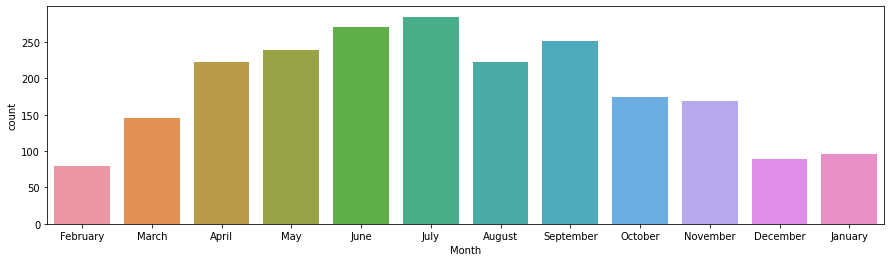

In [ ]:
plt.subplots(figsize=(15, 4))
sns.countplot(df['Month'])

<li>We can see the upward trend from March till August and continues in September as well, may be seasonal effect</li>

<h3>Multivariate Analysis</h3>
Lets check if int columns are correlated with target

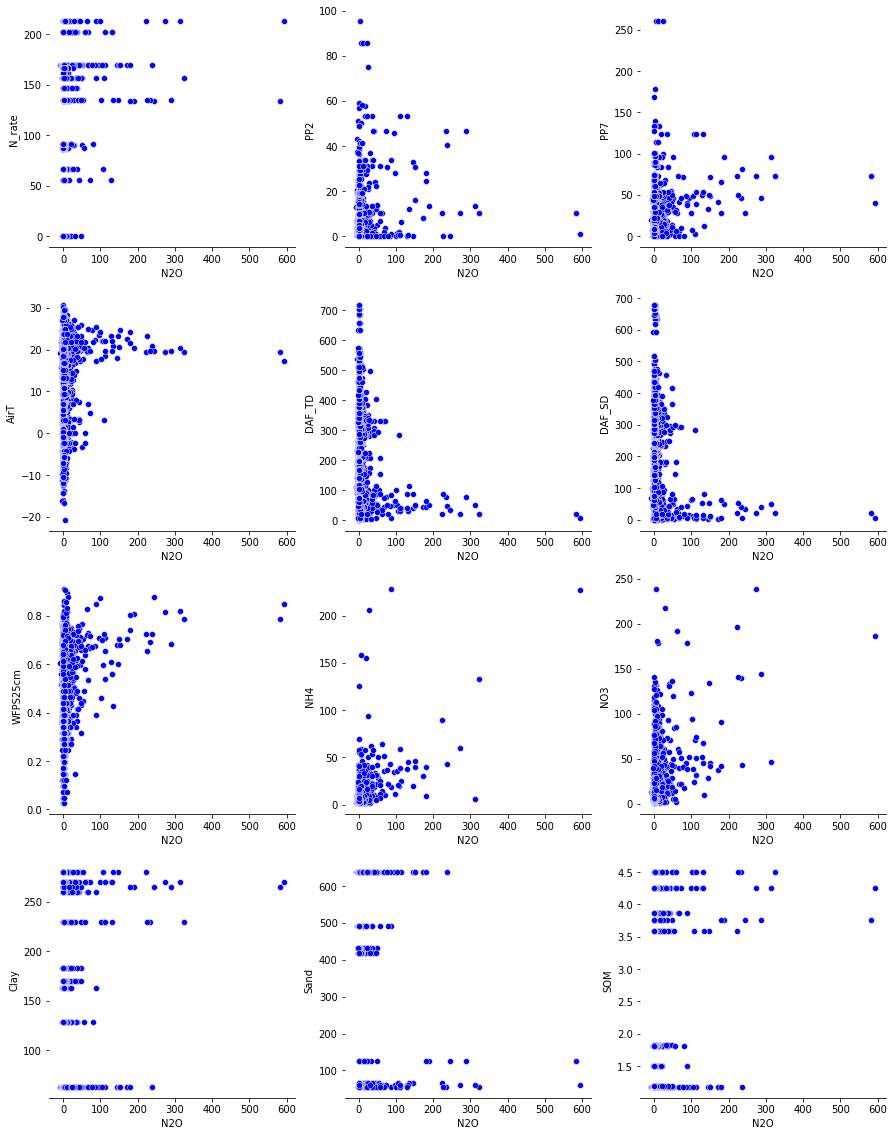

In [ ]:
fig,axes =plt.subplots(4,3,figsize=(15,20))
for x,ax in zip(df_int.columns[2:],axes.flatten()):
    sns.scatterplot(df['N2O'],df_int[x],ax = ax,color ='b',)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)



<li>No clear relation between target and int columns</li>

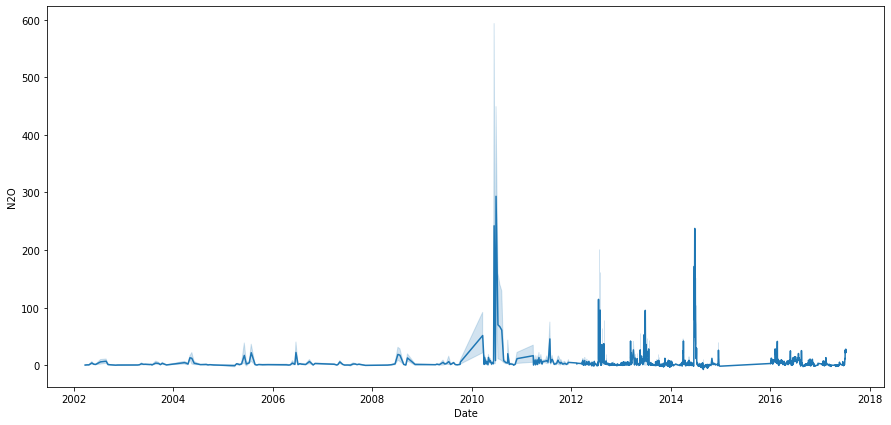

In [ ]:
plt.subplots(figsize=(15,7))
sns.lineplot(df['Date'],df['N2O'],)

<li>We see spikes from 2010 , as we have seen that N20 emission high during JUne, July</li>

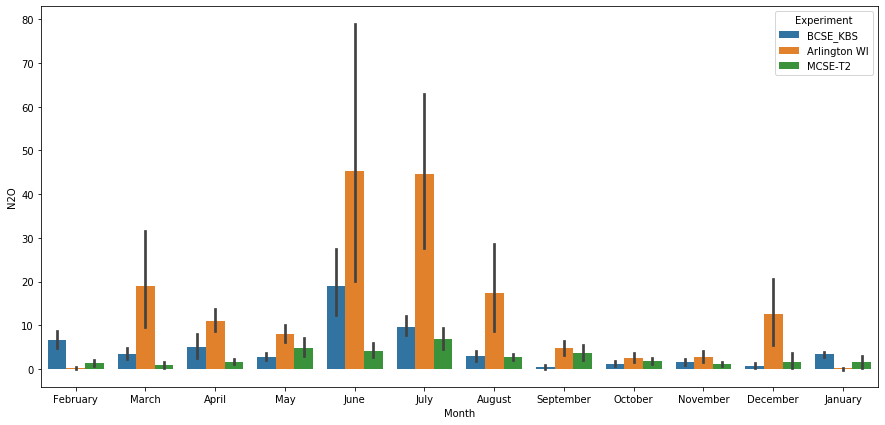

In [ ]:
plt.subplots(figsize=(15,7))
sns.barplot(x =df['Month'],y = df['N2O'],hue =df['Experiment'],) #June July, witnessed highest emission

<li>N2o flux for month june and july is highest and alsofor experiment Arlinh=gton WI</li>

In [ ]:
px.sunburst(df,path=['Experiment','Vegetation'],values='N2O',)


TypeError: ignored

<li>Arlington has just Corn with total flux 8800 and similarly BCSE_KBS with corn veg of 5704</li>
<li>MCSE-T2 has 3 types, least beaing GLYMX and highest is corn 1209</li>

In [ ]:

sns.heatmap(df.drop)

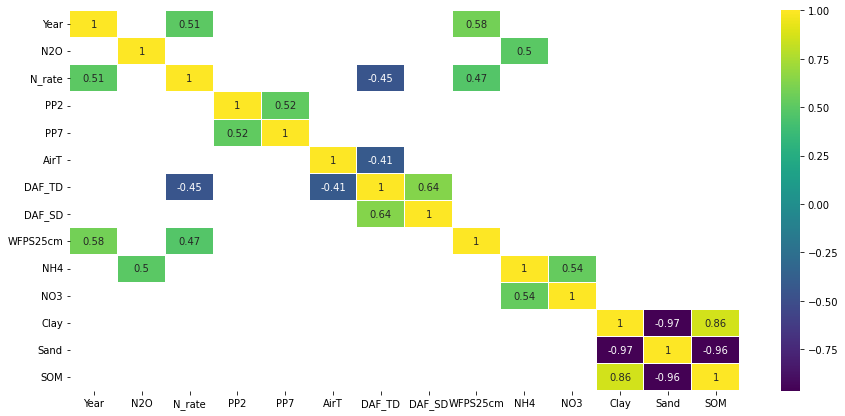

In [ ]:
plt.figure(figsize =(15,7))
corr = df.corr()
sns.heatmap(corr[(corr>=0.4) | (corr<=-0.4)],annot=True,cmap='viridis',linewidth = 0.1)

<h3>we can see that clay,sand,and SOM are highly corelated <h3>

<li>Either drop any two columns , or combine them as single</li>

# Missing Value Imputations

In [ ]:
#before imputing lets check if there is a pattern 
df.isnull().sum()/df.shape[0]*100
#missing values just account of 2, 3 1 percent respectively

Date           0.000000
Year           0.000000
Experiment     0.000000
DataUse        0.000000
Replication    0.000000
Month          0.000000
Vegetation     0.000000
VegType        0.000000
N2O            0.000000
N_rate         0.000000
PP2            0.000000
PP7            0.000000
AirT           0.000000
DAF_TD         0.000000
DAF_SD         0.000000
WFPS25cm       2.315227
NH4            3.383793
NO3            1.335708
Clay           0.000000
Sand           0.000000
SOM            0.000000
dtype: float64

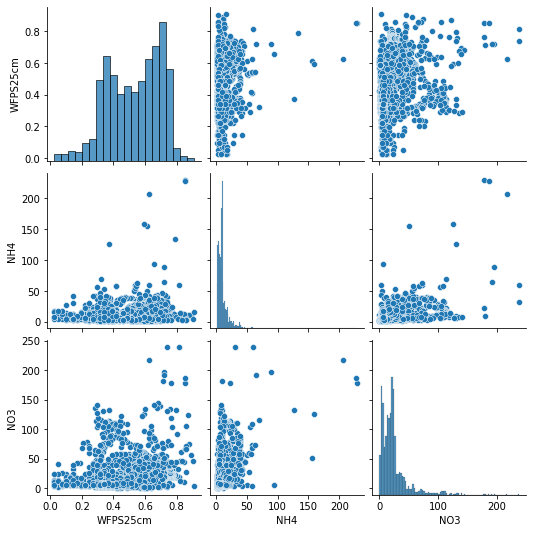

In [ ]:
sns.pairplot(df[['WFPS25cm','NH4','NO3']])

In [ ]:
#lets see if missing values have anything in common
import missingno as msno

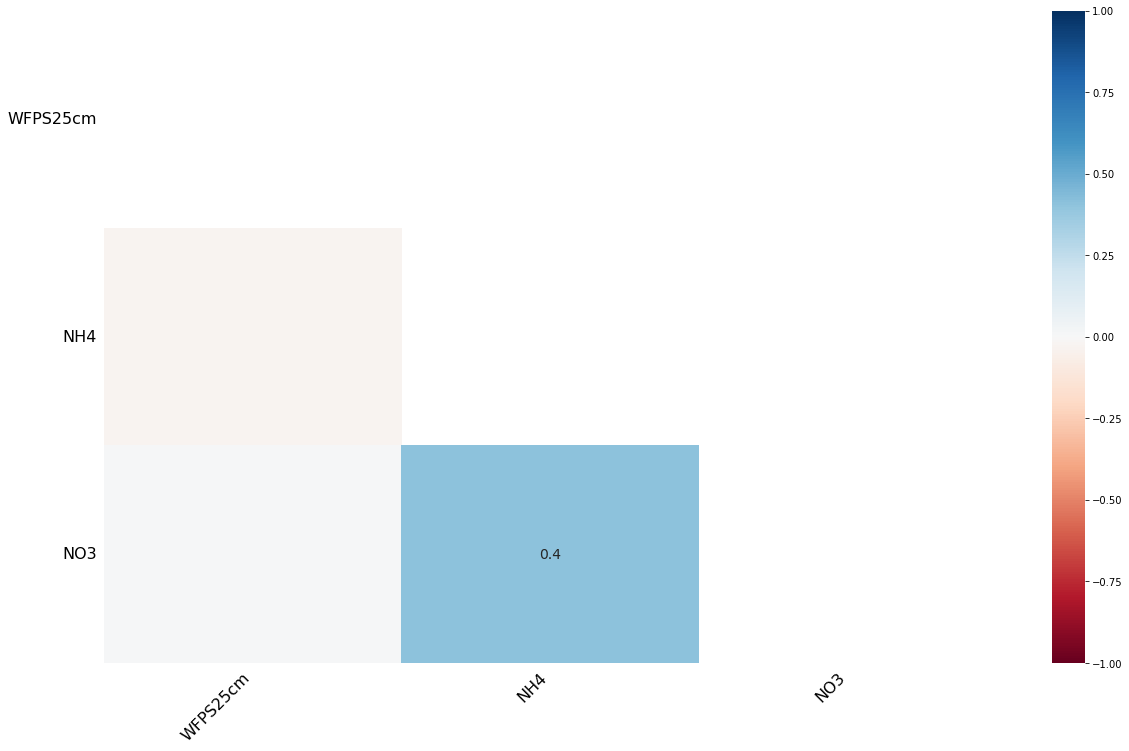

In [ ]:
msno.heatmap(df)#we can see that Nh4 and No3 are 40% correlated

In [ ]:
df1 = df.copy()

In [ ]:
df1['WFPS25cm'] = df.groupby(['Year','Month'])['WFPS25cm'].apply(lambda x:x.fillna(x.mean()))
df1['NH4'] = df.groupby(['Year','Month'])['NH4'].apply(lambda x:x.fillna(x.median()))
df1['NO3'] = df.groupby(['Year','Month'])['NO3'].apply(lambda x:x.fillna(x.median()))

df1['WFPS25cm'] = df.groupby(['Year'])['WFPS25cm'].apply(lambda x:x.fillna(x.mean()))


In [ ]:
df1['N2O'].describe()

count    2246.000000
mean        7.468610
std        28.488257
min        -7.415297
25%         0.504316
50%         1.972058
75%         5.187618
max       593.072000
Name: N2O, dtype: float64

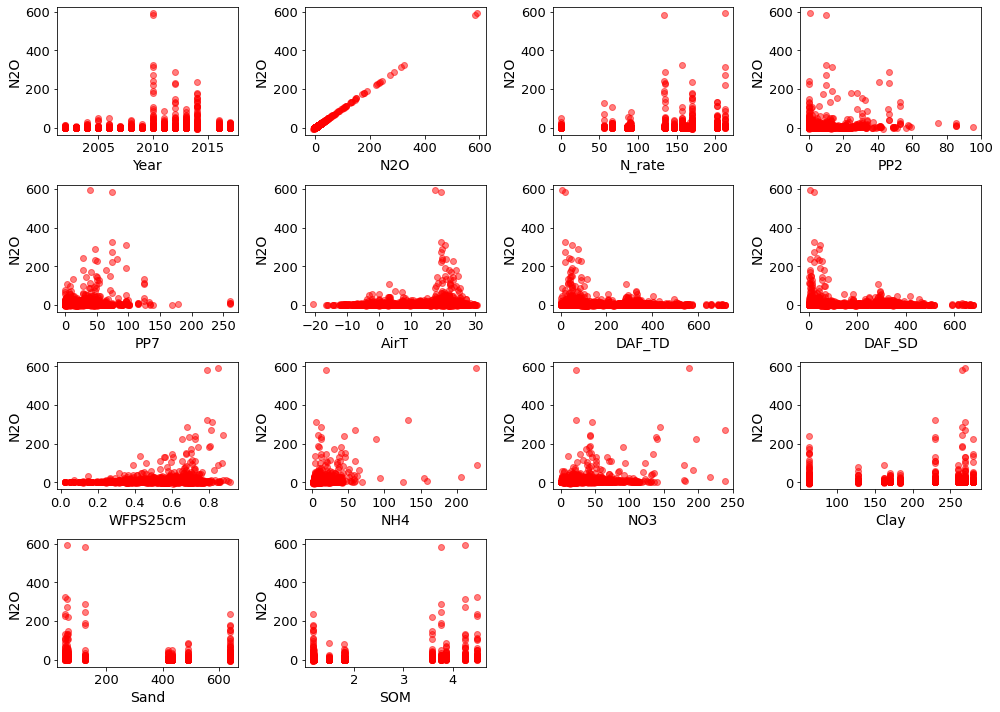

In [ ]:
plt.figure(figsize=(14,10))
i=0

for col in df1.select_dtypes(exclude=object).columns[1:]:
    if i < 15:
        ax = plt.subplot(4,4,i+1)
        plt.scatter(data=df1, x=col, y='N2O', color='r', alpha=0.5)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('N2O', fontsize=14)
    i +=1
plt.tight_layout()

<li>N20 above 400 is outlier</li>
<li>PP2 70, pp7 200</li>
<li>for Nh4 and N03 we can clip it to 200 and 150</li>

<h2>Preprocessing<h2>

In [ ]:
df1 = df1[(df1['N2O']>=0)]

count    2000.000000
mean        1.401242
std         1.040248
min         0.000000
25%         0.646065
50%         1.209251
75%         1.923835
max         6.387001
Name: N2O, dtype: float64

In [ ]:
pos_sk = []
neg_sk =[]
for col in df1.select_dtypes(exclude=object).columns:

  if col not in ['N_rate','Clay','Sand','SOM','Date','Year']:
    if df1[col].skew()<-0.75:
      neg_sk.append(col)
    elif df1[col].skew()>0.75:
      pos_sk.append(col)  

In [ ]:
print(neg_sk)
print(pos_sk)

[]
['N2O', 'PP2', 'PP7', 'DAF_TD', 'NH4', 'NO3']


In [ ]:
df2 = df1.copy()
for col in pos_sk:
  df2[col] =np.log1p(df2[col])

--------Distrbution before log 


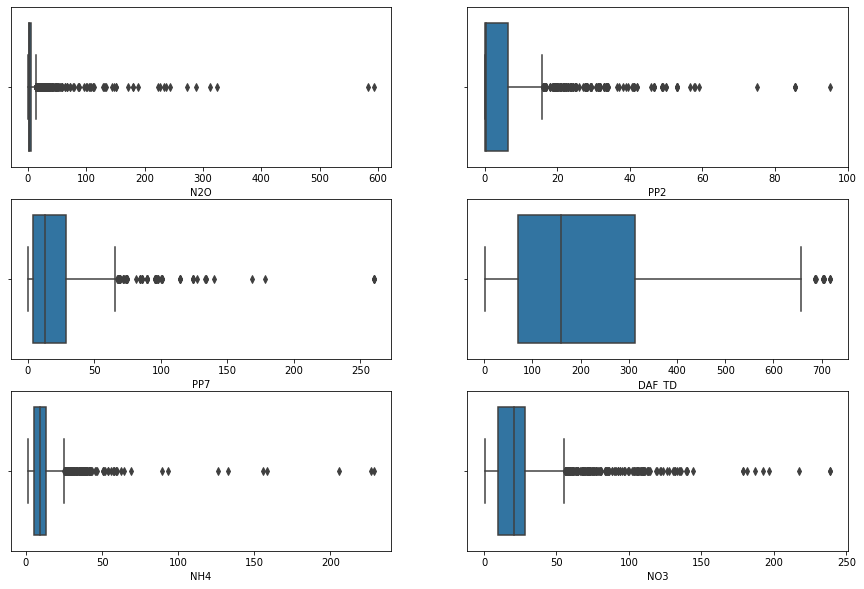

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(15,10))
print("--------Distrbution before log ")
for col, ax in zip(pos_sk,ax.flatten()):
  sns.boxplot(df1[col],ax=ax)
  

-------- log Transform -----------


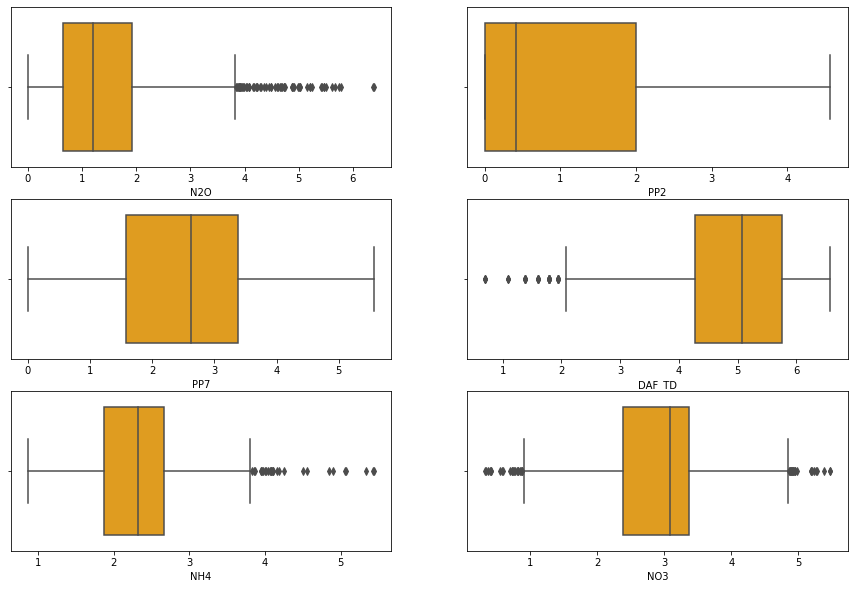

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(15,10))
print("-------- log Transform -----------")
for col, ax in zip(pos_sk,ax.flatten()):
  sns.boxplot(df2[col],ax=ax,color='orange')
  

In [ ]:
# Winsorizing the data
for feat in pos_sk:
    q1 = df2[feat].quantile(0.25)
    q3 = df2[feat].quantile(0.75)
    iqr = q3 - q1
    upper = q3+(1.5*iqr)
    lower = q1-(1.5*iqr)
    df2[feat] = np.where(df2[feat]>upper, upper, np.where(df2[feat]<lower, lower, df2[feat]))

-------- Removnig Outliers -----------


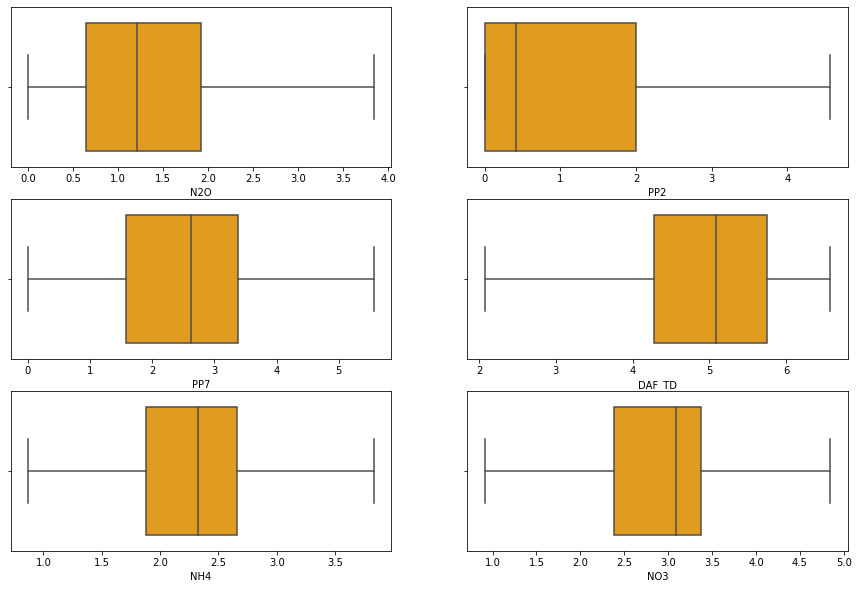

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(15,10))
print("-------- Removnig Outliers -----------")
for col, ax in zip(pos_sk,ax.flatten()):
  sns.boxplot(df2[col],ax=ax,color='orange')
  

In [ ]:
df2[['Clay','Sand','SOM']] =  np.ceil(df2[['Clay','Sand','SOM']])

In [ ]:
#will drop Vegtype since its variance is low,DataUse also.

from scipy.stats import chi2_contingency
def chi2(data,col):
    contigency_data = pd.crosstab(data[col],data['N2O'])

    stat,pvalue,dof,exp =chi2_contingency(contigency_data)

    print('stat=%.3f, p=%.3f' % (stat, pvalue))
    if pvalue > 0.05:
        print(f'No effect of {col} on target')
    else:
        print(f'There is a effect of {col} on target')
        
for col in ['Experiment','Replication','Month','Vegetation','DataUse','VegType','Clay','Sand','SOM']:
       chi2(df2,col)     
        

stat=3838.281, p=0.000
There is a effect of Experiment on target
stat=6354.368, p=0.145
No effect of Replication on target
stat=17668.496, p=0.003
There is a effect of Month on target
stat=2811.837, p=1.000
No effect of Vegetation on target
stat=1927.586, p=0.000
There is a effect of DataUse on target
stat=0.000, p=1.000
No effect of VegType on target
stat=14584.452, p=0.001
There is a effect of Clay on target
stat=12717.753, p=0.061
No effect of Sand on target
stat=3757.582, p=0.000
There is a effect of SOM on target


<h2>According to Chi2, Vegtype,Replication,Vegetation,Sand has no effect on target</h2>


In [ ]:
df2.drop(df2[['Vegetation','Replication','Sand','VegType']],axis=1,inplace=True)

In [ ]:
for col in ['Month','Vegetation','DataUse','Replication']:
  dummy = pd.get_dummies(df1[col],drop_first=True)
  df1.drop(col,axis=1,inplace=True)
  df1 = df1.join(dummy)

In [ ]:
df2

,Date,Year,Experiment,DataUse,Month,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM
0,2012-02-09,2012,BCSE_KBS,Building,February,1.588570,170,0.000000,0.000000,-2.00,5.624018,241,0.666508,2.488761,3.175585,63.0,2.0
1,2012-02-10,2012,BCSE_KBS,Building,February,1.160089,170,0.000000,0.000000,-2.40,5.627621,242,0.640608,2.485580,3.176368,63.0,2.0
2,2012-02-18,2012,BCSE_KBS,Building,February,1.513498,170,1.458615,2.265921,0.30,5.655992,250,0.728085,2.470780,3.187258,63.0,2.0
3,2012-02-19,2012,BCSE_KBS,Building,February,1.468535,170,0.000000,2.211566,-3.80,5.659482,251,0.686872,2.472310,3.189323,63.0,2.0
4,2012-03-16,2012,BCSE_KBS,Building,March,1.373153,170,0.703098,2.239645,17.60,5.746203,277,0.716221,2.416338,3.227116,63.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,2013-10-16,2013,MCSE-T2,Testing,October,1.105257,91,1.570697,2.211566,10.81,5.123964,167,0.341428,2.795936,2.045238,170.0,2.0
2241,2013-10-16,2013,MCSE-T2,Testing,October,0.970779,91,1.570697,2.211566,10.81,5.123964,167,0.390203,2.893799,1.917464,129.0,2.0
2242,2013-11-15,2013,MCSE-T2,Testing,November,0.688135,91,0.000000,2.211566,5.64,5.288267,197,0.317040,1.890810,1.860955,163.0,2.0
2244,2013-11-15,2013,MCSE-T2,Testing,November,0.262364,91,0.000000,2.211566,5.64,5.288267,197,0.365815,1.534053,2.244351,170.0,2.0


In [29]:
months_dict.keys()

dict_keys(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

In [23]:
months_dict = {'January': 1,
 'February': 2,
 'March': 3,
 'April': 4,
 'May': 5,
 'June': 6,
 'July': 7,
 'August': 8,
 'September': 9,
 'October': 10,
 'November': 11,
 'December': 12}

crops_dict = {"Corn": 1, "GLYMX": 2, "TRIAE": 3}
datause_dict = {"Building": 1, "Testing": 0}

df2['Experiment'] = df2['Experiment'].map({"Arlington WI":1,"MCSE-T2":2,"BCSE_KBS":3})

NameError: ignored

In [ ]:
df2.columns

Index(['Date', 'Year', 'Experiment', 'DataUse', 'Month', 'N2O', 'N_rate',
       'PP2', 'PP7', 'AirT', 'DAF_TD', 'DAF_SD', 'WFPS25cm', 'NH4', 'NO3',
       'Clay', 'SOM'],
      dtype='object')

In [ ]:
X = df2[['Year', 'Experiment', 'DataUse', 'Month','N_rate',
       'PP2', 'PP7', 'AirT', 'DAF_TD', 'DAF_SD', 'WFPS25cm', 'NH4', 'NO3',
       'Clay', 'SOM']]
y = df2['N2O']       

In [ ]:
from sklearn.model_selection import cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=7)

RandomForestRegressor with feature IMportance
DecisionTreeRegressor with feature IMportance
XGBRegressor with feature IMportance
LGBMRegressor with feature IMportance
Learning rate set to 0.043179
0:	learn: 0.9522829	total: 3.31ms	remaining: 3.31s
1:	learn: 0.9383933	total: 6.01ms	remaining: 3s
2:	learn: 0.9274556	total: 8.75ms	remaining: 2.91s
3:	learn: 0.9163153	total: 11.5ms	remaining: 2.86s
4:	learn: 0.9042976	total: 14.2ms	remaining: 2.83s
5:	learn: 0.8943423	total: 16.8ms	remaining: 2.79s
6:	learn: 0.8844160	total: 19.4ms	remaining: 2.76s
7:	learn: 0.8767554	total: 22.1ms	remaining: 2.74s
8:	learn: 0.8678825	total: 24.9ms	remaining: 2.74s
9:	learn: 0.8602405	total: 27.5ms	remaining: 2.72s
10:	learn: 0.8528546	total: 30.1ms	remaining: 2.7s
11:	learn: 0.8446301	total: 32.8ms	remaining: 2.7s
12:	learn: 0.8375724	total: 35.4ms	remaining: 2.69s
13:	learn: 0.8291527	total: 38.2ms	remaining: 2.69s
14:	learn: 0.8222809	total: 40.8ms	remaining: 2.68s
15:	learn: 0.8162250	total: 43.5ms	rem

,MSE,MAE,R2_score
RandomForestRegressor,0.371649,0.461686,0.591399
DecisionTreeRegressor,0.738562,0.616456,0.188004
XGBRegressor,0.406292,0.484971,0.553311
LGBMRegressor,0.368934,0.466406,0.594384
CatBoostRegressor,0.357193,0.455998,0.607292


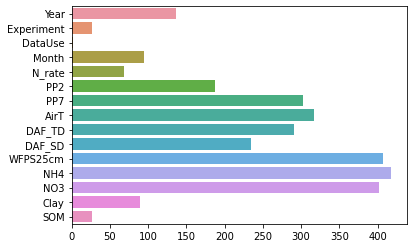

In [ ]:
algos = {
    "rf": RandomForestRegressor(),
    "dt": DecisionTreeRegressor(),
    'xgb':XGBRegressor(),
    'lgbm':LGBMRegressor(),
    'cat':cb.CatBoostRegressor()
}

mse=[]
mae=[]
r2=[]
algo=[]

for key, reg in algos.items():
    algo.append(reg.__class__.__name__)
    reg.fit(X_train, y_train)
    try:
      print(f'{reg.__class__.__name__} with feature IMportance')
      sns.barplot(reg.feature_importances_,X_train.columns)
    except:
      pass  
    pred=reg.predict(X_test)
    mse.append((mean_squared_error(y_test,pred)))
    mae.append((mean_absolute_error(y_test,pred)))
    r2.append((r2_score(y_test,pred)))
    
metrics=pd.DataFrame({'MSE':mse,'MAE':mae,'R2_score':r2},index=algo)
metrics

In [4]:
import catboost as cb

ModuleNotFoundError: ignored

CatBoostRegressor with feature IMportance


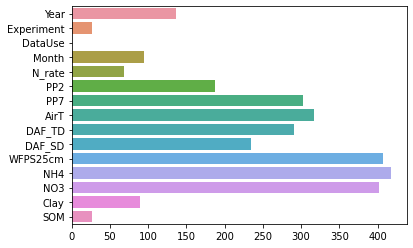

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
sns.barplot(lgbm.feature_importances_,X_train.columns)
pred=lgbm.predict(X_test)
mse.append((mean_squared_error(y_test,pred)))
mae.append((mean_absolute_error(y_test,pred)))
r2.append((r2_score(y_test,pred)))

Learning rate set to 0.043179
0:	learn: 0.9522829	total: 2.8ms	remaining: 2.8s
1:	learn: 0.9383933	total: 5.33ms	remaining: 2.66s
2:	learn: 0.9274556	total: 9.48ms	remaining: 3.15s
3:	learn: 0.9163153	total: 11.8ms	remaining: 2.95s
4:	learn: 0.9042976	total: 14.3ms	remaining: 2.84s
5:	learn: 0.8943423	total: 18.6ms	remaining: 3.09s
6:	learn: 0.8844160	total: 21ms	remaining: 2.98s
7:	learn: 0.8767554	total: 23.5ms	remaining: 2.91s
8:	learn: 0.8678825	total: 27.7ms	remaining: 3.05s
9:	learn: 0.8602405	total: 30.1ms	remaining: 2.98s
10:	learn: 0.8528546	total: 32.4ms	remaining: 2.91s
11:	learn: 0.8446301	total: 35.8ms	remaining: 2.95s
12:	learn: 0.8375724	total: 38.3ms	remaining: 2.91s
13:	learn: 0.8291527	total: 42.8ms	remaining: 3.01s
14:	learn: 0.8222809	total: 45.6ms	remaining: 2.99s
15:	learn: 0.8162250	total: 48ms	remaining: 2.95s
16:	learn: 0.8107889	total: 51.7ms	remaining: 2.99s
17:	learn: 0.8043124	total: 54.5ms	remaining: 2.97s
18:	learn: 0.7986188	total: 56.8ms	remaining: 2.93

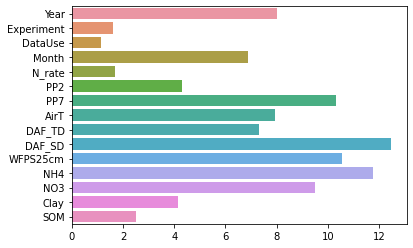

In [ ]:
cat = cb.CatBoostRegressor()
cat.fit(X_train, y_train)
sns.barplot(cat.feature_importances_,X_train.columns)
pred=cat.predict(X_test)
mse.append((mean_squared_error(y_test,pred)))
mae.append((mean_absolute_error(y_test,pred)))
r2.append((r2_score(y_test,pred)))

In [ ]:
col_to_consider = pd.DataFrame(cat.feature_importances_,X_train.columns,columns=['imp']).sort_values(by='imp',ascending=False)[:-4].index.to_list()

Learning rate set to 0.043179
0:	learn: 0.9518949	total: 2.75ms	remaining: 2.75s
1:	learn: 0.9394560	total: 9.79ms	remaining: 4.88s
2:	learn: 0.9272998	total: 17.8ms	remaining: 5.91s
3:	learn: 0.9175442	total: 20.4ms	remaining: 5.08s
4:	learn: 0.9069036	total: 25ms	remaining: 4.98s
5:	learn: 0.8955974	total: 34.3ms	remaining: 5.68s
6:	learn: 0.8850947	total: 36.9ms	remaining: 5.24s
7:	learn: 0.8749260	total: 46ms	remaining: 5.7s
8:	learn: 0.8667007	total: 48.5ms	remaining: 5.34s
9:	learn: 0.8579960	total: 51.7ms	remaining: 5.12s
10:	learn: 0.8503437	total: 60.4ms	remaining: 5.43s
11:	learn: 0.8440233	total: 63ms	remaining: 5.18s
12:	learn: 0.8365865	total: 68.2ms	remaining: 5.18s
13:	learn: 0.8291167	total: 88ms	remaining: 6.2s
14:	learn: 0.8228152	total: 97.1ms	remaining: 6.38s
15:	learn: 0.8157192	total: 105ms	remaining: 6.43s
16:	learn: 0.8107668	total: 113ms	remaining: 6.56s
17:	learn: 0.8042832	total: 116ms	remaining: 6.33s
18:	learn: 0.7994757	total: 121ms	remaining: 6.22s
19:	le

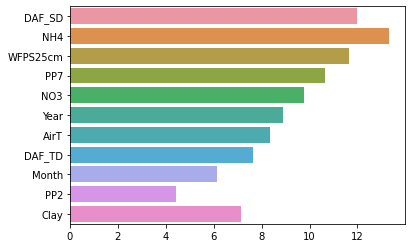

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(X[col_to_consider],y, test_size=0.3, random_state=7)

cat = cb.CatBoostRegressor()
cat.fit(X_train, y_train)
sns.barplot(cat.feature_importances_,X_train.columns)
pred=cat.predict(X_test)
print((mean_squared_error(y_test,pred)))
print((mean_absolute_error(y_test,pred)))
print((r2_score(y_test,pred)))

In [ ]:

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
pred=lgbm.predict(X_test)
print((mean_squared_error(y_test,pred)))
print((mean_absolute_error(y_test,pred)))
print((r2_score(y_test,pred)))

0.3715277093186689
0.47074442184744736
0.5915323003834183


In [ ]:
lgbm = RandomForestRegressor(**param)
lgbm.fit(X_train, y_train)
pred=lgbm.predict(X_test)
print((mean_squared_error(y_test,pred)))
print((mean_absolute_error(y_test,pred)))
print((r2_score(y_test,pred)))

0.5408211001297523
0.5787013636524472
0.40540652787587794


In [ ]:
params = {
        'min_child_weight': [3, 8 ,12],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3,6,10],
        'n_estimators':np.arange(100,1000,200)
        }

from sklearn.model_selection import RandomizedSearchCV
folds = KFold(n_splits = 3,shuffle=True,)

xgb = XGBRegressor(learning_rate=0.01)

rs=RandomizedSearchCV(xgb,params,scoring='r2',cv=folds.split(X,y),n_iter=5)
rs.fit(X,y)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6211e6e250>,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.01,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=...
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=No

In [ ]:
def model(obj):
  obj.fit(X_train,y_train)
  pred = obj.predict(X_test)
  print('r2_score',r2_score(y_test,pred))
  print('mse',mean_squared_error(y_test,pred))
  print('mae',mean_absolute_error(y_test,pred))

In [ ]:
xgb=XGBRegressor(**rs.best_params_)
model(xgb)

r2_score 0.5638451344515762
mse 0.3967109719018277
mae 0.47110831752576027


In [ ]:
import joblib

with open('./xgb_1.pkl.compressed', 'wb') as m:
    joblib.dump(xgb, m, compress=3)
    
    

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=42)
    param = {
        
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    r2 = r2_score(test_y, preds)
    
    return r2
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)    


[I 2021-12-17 14:30:31,359] A new study created in memory with name: no-name-acc307f6-9a82-4cb8-a0dd-fcc3b595d7a7
[I 2021-12-17 14:30:36,792] Trial 0 finished with value: 0.5170684104108498 and parameters: {'reg_alpha': 2.018580339130088, 'reg_lambda': 0.9090502880616476, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 716, 'min_child_samples': 255, 'min_data_per_groups': 35}. Best is trial 0 with value: 0.5170684104108498.
[I 2021-12-17 14:30:38,944] Trial 1 finished with value: 0.5442601374903617 and parameters: {'reg_alpha': 0.11694905122931949, 'reg_lambda': 1.6980475907314565, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 186, 'min_child_samples': 247, 'min_data_per_groups': 1}. Best is trial 1 with value: 0.5442601374903617.
[I 2021-12-17 14:30:46,956] Trial 2 finished with value: 0.5707948424206752 and parameters: {'reg_alpha': 0.09737452488206179, 'reg_lambda': 0.152060985617087

Number of finished trials: 50
Best trial: {'reg_alpha': 0.8207302174013715, 'reg_lambda': 6.02822928722445, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 455, 'min_child_samples': 2, 'min_data_per_groups': 100}


In [ ]:
lgbm=LGBMRegressor(**study.best_params)
lgbm.fit(X_train,y_train)
pred = lgbm.predict(X_test)
print(r2_score(y_test,pred))

0.4001648490399615


In [ ]:
grid = {
        'learning_rate': [0.05, 0.005, 0.0005],
        
        'l2_leaf_reg': [1, 3, 5, 9],
        'max_depth': [3,4,5],
        'n_estimators':[100, 200, 300]
        }

cat = cb.CatBoostRegressor()
folds = KFold(n_splits = 3,shuffle=True,)

rs=RandomizedSearchCV(cat,grid,scoring='r2',cv=folds.split(X,y),n_iter=5)
rs.fit(X,y)

0:	learn: 0.9650053	total: 1.35ms	remaining: 134ms
1:	learn: 0.9648830	total: 3.02ms	remaining: 148ms
2:	learn: 0.9647549	total: 4.46ms	remaining: 144ms
3:	learn: 0.9646132	total: 5.88ms	remaining: 141ms
4:	learn: 0.9644815	total: 7.33ms	remaining: 139ms
5:	learn: 0.9643640	total: 8.83ms	remaining: 138ms
6:	learn: 0.9642395	total: 9.97ms	remaining: 132ms
7:	learn: 0.9641234	total: 11.4ms	remaining: 131ms
8:	learn: 0.9639899	total: 12.9ms	remaining: 130ms
9:	learn: 0.9638685	total: 14.3ms	remaining: 129ms
10:	learn: 0.9637483	total: 15.8ms	remaining: 127ms
11:	learn: 0.9636211	total: 16.9ms	remaining: 124ms
12:	learn: 0.9634946	total: 18.3ms	remaining: 123ms
13:	learn: 0.9633714	total: 19.7ms	remaining: 121ms
14:	learn: 0.9632476	total: 21.1ms	remaining: 120ms
15:	learn: 0.9631249	total: 22.6ms	remaining: 118ms
16:	learn: 0.9630018	total: 24ms	remaining: 117ms
17:	learn: 0.9628777	total: 25.4ms	remaining: 116ms
18:	learn: 0.9627611	total: 26.9ms	remaining: 114ms
19:	learn: 0.9626414	tot

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6211ebced0>,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f621deed610>,
                   n_iter=5,
                   param_distributions={'l2_leaf_reg': [1, 3, 5, 9],
                                        'learning_rate': [0.05, 0.005, 0.0005],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300]},
                   scoring='r2')

In [ ]:
cat=cb.CatBoostRegressor(**rs.best_params_)
model(cat)




0:	learn: 0.9532452	total: 3.44ms	remaining: 684ms
1:	learn: 0.9411326	total: 5.67ms	remaining: 562ms
2:	learn: 0.9310793	total: 9.02ms	remaining: 593ms
3:	learn: 0.9203755	total: 11.9ms	remaining: 583ms
4:	learn: 0.9109487	total: 14.8ms	remaining: 578ms
5:	learn: 0.9026118	total: 31.9ms	remaining: 1.03s
6:	learn: 0.8954650	total: 33.6ms	remaining: 927ms
7:	learn: 0.8875317	total: 35.2ms	remaining: 846ms
8:	learn: 0.8806546	total: 37.7ms	remaining: 799ms
9:	learn: 0.8753898	total: 45.5ms	remaining: 864ms
10:	learn: 0.8690383	total: 47.1ms	remaining: 809ms
11:	learn: 0.8640475	total: 48.7ms	remaining: 763ms
12:	learn: 0.8580717	total: 51.8ms	remaining: 745ms
13:	learn: 0.8529481	total: 59.1ms	remaining: 785ms
14:	learn: 0.8471239	total: 62ms	remaining: 765ms
15:	learn: 0.8431013	total: 65ms	remaining: 747ms
16:	learn: 0.8377165	total: 67.9ms	remaining: 731ms
17:	learn: 0.8326953	total: 70.9ms	remaining: 717ms
18:	learn: 0.8284081	total: 73.8ms	remaining: 703ms
19:	learn: 0.8245929	total

In [ ]:
pd.concat([X,y],axis=1).to_csv('preprocess.csv',index=False)

In [ ]:
import joblib

with open('./catboost.pkl.compressed', 'wb') as m:
    joblib.dump(cat, m, compress=3)
    
    

In [ ]:
pip install optuna

In [ ]:
import optuna
rf_param_1, rf_score_1 = tuner(rf_objective)
rf1 = RandomForestRegressor(**rf_param_1)
print("\n")


[I 2021-12-17 13:50:10,882] A new study created in memory with name: no-name-c1186659-b57b-4223-a167-373fcbf0d0ea
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 191
building tree 2 of 191
building tree 3 of 191
building tree 4 of 191
building tree 5 of 191
building tree 6 of 191
building tree 7 of 191
building tree 8 of 191
building tree 9 of 191
building tree 10 of 191
building tree 11 of 191
building tree 12 of 191
building tree 13 of 191
building tree 14 of 191
building tree 15 of 191
building tree 16 of 191
building tree 17 of 191
building tree 18 of 191
building tree 19 of 191
building tree 20 of 191
building tree 21 of 191
building tree 22 of 191
building tree 23 of 191
building tree 24 of 191
building tree 25 of 191
building tree 26 of 191
building tree 27 of 191
building tree 28 of 191
building tree 29 of 191
building tree 30 of 191
building tree 31 of 191
building tree 32 of 191
building tree 33 of 191
building tree 34 of 191
building tree 35 of 191
building tree 36 of 191
building tree 37 of 191
building tree 38 of 191
building tree 39 of 191
building tree 40 of 191
building tree 41 of 191
building tree 42 of 191
b

[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 191
building tree 2 of 191
building tree 3 of 191
building tree 4 of 191
building tree 5 of 191
building tree 6 of 191
building tree 7 of 191
building tree 8 of 191
building tree 9 of 191
building tree 10 of 191
building tree 11 of 191
building tree 12 of 191
building tree 13 of 191
building tree 14 of 191
building tree 15 of 191
building tree 16 of 191
building tree 17 of 191
building tree 18 of 191
building tree 19 of 191
building tree 20 of 191
building tree 21 of 191
building tree 22 of 191
building tree 23 of 191
building tree 24 of 191
building tree 25 of 191
building tree 26 of 191
building tree 27 of 191
building tree 28 of 191
building tree 29 of 191
building tree 30 of 191
building tree 31 of 191
building tree 32 of 191
building tree 33 of 191
building tree 34 of 191
building tree 35 of 191
building tree 36 of 191
building tree 37 of 191
building tree 38 of 191
building tree 39 of 191
building tree 40 of 191
building tree 41 of 191
building tree 42 of 191
b

[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 191
building tree 2 of 191
building tree 3 of 191
building tree 4 of 191
building tree 5 of 191
building tree 6 of 191
building tree 7 of 191
building tree 8 of 191
building tree 9 of 191
building tree 10 of 191
building tree 11 of 191
building tree 12 of 191
building tree 13 of 191
building tree 14 of 191
building tree 15 of 191
building tree 16 of 191
building tree 17 of 191
building tree 18 of 191
building tree 19 of 191
building tree 20 of 191
building tree 21 of 191
building tree 22 of 191
building tree 23 of 191
building tree 24 of 191
building tree 25 of 191
building tree 26 of 191
building tree 27 of 191
building tree 28 of 191
building tree 29 of 191
building tree 30 of 191
building tree 31 of 191
building tree 32 of 191
building tree 33 of 191
building tree 34 of 191
building tree 35 of 191
building tree 36 of 191
building tree 37 of 191
building tree 38 of 191
building tree 39 of 191
building tree 40 of 191
building tree 41 of 191
building tree 42 of 191
b

[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 191 out of 191 | elapsed:    0.1s finished
[I 2021-12-17 13:50:19,963] Trial 0 finished with value: -0.8725277137792148 and parameters: {'n_estimators': 191, 'max_depth': 14, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_samples': 0.7725893744392024, 'ccp_alpha': 0.07233875569699283}. Best is trial 0 with value: -0.8725277137792148.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 193
building tree 2 of 193
building tree 3 of 193
building tree 4 of 193
building tree 5 of 193
building tree 6 of 193
building tree 7 of 193
building tree 8 of 193
building tree 9 of 193
building tree 10 of 193
building tree 11 of 193
building tree 12 of 193
building tree 13 of 193
building tree 14 of 193
building tree 15 of 193
building tree 16 of 193
building tree 17 of 193
building tree 18 of 193
building tree 19 of 193
building tree 20 of 193
building tree 21 of 193
building tree 22 of 193
building tree 23 of 193
building tree 24 of 193
building tree 25 of 193
building tree 26 of 193
building tree 27 of 193
building tree 28 of 193
building tree 29 of 193
building tree 30 of 193
building tree 31 of 193
building tree 32 of 193
building tree 33 of 193
building tree 34 of 193
building tree 35 of 193
building tree 36 of 193
building tree 37 of 193
building tree 38 of 193
building tree 39 of 193
building tree 40 of 193
building tree 41 of 193
building tree 42 of 193
b

[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 193
building tree 2 of 193
building tree 3 of 193
building tree 4 of 193
building tree 5 of 193
building tree 6 of 193
building tree 7 of 193
building tree 8 of 193
building tree 9 of 193
building tree 10 of 193
building tree 11 of 193
building tree 12 of 193
building tree 13 of 193
building tree 14 of 193
building tree 15 of 193
building tree 16 of 193
building tree 17 of 193
building tree 18 of 193
building tree 19 of 193
building tree 20 of 193
building tree 21 of 193
building tree 22 of 193
building tree 23 of 193
building tree 24 of 193
building tree 25 of 193
building tree 26 of 193
building tree 27 of 193
building tree 28 of 193
building tree 29 of 193
building tree 30 of 193
building tree 31 of 193
building tree 32 of 193
building tree 33 of 193
building tree 34 of 193
building tree 35 of 193
building tree 36 of 193
building tree 37 of 193
building tree 38 of 193
building tree 39 of 193
building tree 40 of 193
building tree 41 of 193
building tree 42 of 193
b

[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 193
building tree 2 of 193
building tree 3 of 193
building tree 4 of 193
building tree 5 of 193
building tree 6 of 193
building tree 7 of 193
building tree 8 of 193
building tree 9 of 193
building tree 10 of 193
building tree 11 of 193
building tree 12 of 193
building tree 13 of 193
building tree 14 of 193
building tree 15 of 193
building tree 16 of 193
building tree 17 of 193
building tree 18 of 193
building tree 19 of 193
building tree 20 of 193
building tree 21 of 193
building tree 22 of 193
building tree 23 of 193
building tree 24 of 193
building tree 25 of 193
building tree 26 of 193
building tree 27 of 193
building tree 28 of 193
building tree 29 of 193
building tree 30 of 193
building tree 31 of 193
building tree 32 of 193
building tree 33 of 193
building tree 34 of 193
building tree 35 of 193
building tree 36 of 193
building tree 37 of 193
building tree 38 of 193
building tree 39 of 193
building tree 40 of 193
building tree 41 of 193
building tree 42 of 193
b

[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    0.1s finished
[I 2021-12-17 13:50:29,008] Trial 1 finished with value: -0.7272637894352755 and parameters: {'n_estimators': 193, 'max_depth': 13, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_samples': 0.9293916827268826, 'ccp_alpha': 0.007557482353771455}. Best is trial 1 with value: -0.7272637894352755.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 105
building tree 2 of 105
building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
b

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 105
building tree 2 of 105
building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
b

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 105
building tree 2 of 105
building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
b

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.0s finished
[I 2021-12-17 13:50:30,678] Trial 2 finished with value: -0.8523517244137486 and parameters: {'n_estimators': 105, 'max_depth': 2, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_samples': 0.3429339888646465, 'ccp_alpha': 0.03804122935579344}. Best is trial 1 with value: -0.7272637894352755.



building tree 58 of 105
building tree 59 of 105
building tree 60 of 105
building tree 61 of 105
building tree 62 of 105
building tree 63 of 105
building tree 64 of 105
building tree 65 of 105
building tree 66 of 105
building tree 67 of 105
building tree 68 of 105
building tree 69 of 105
building tree 70 of 105
building tree 71 of 105
building tree 72 of 105
building tree 73 of 105
building tree 74 of 105
building tree 75 of 105
building tree 76 of 105
building tree 77 of 105
building tree 78 of 105
building tree 79 of 105
building tree 80 of 105
building tree 81 of 105
building tree 82 of 105
building tree 83 of 105
building tree 84 of 105
building tree 85 of 105
building tree 86 of 105
building tree 87 of 105
building tree 88 of 105
building tree 89 of 105
building tree 90 of 105
building tree 91 of 105
building tree 92 of 105
building tree 93 of 105
building tree 94 of 105
building tree 95 of 105
building tree 96 of 105
building tree 97 of 105
building tree 98 of 105
building tree 9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 127
building tree 2 of 127
building tree 3 of 127
building tree 4 of 127
building tree 5 of 127
building tree 6 of 127
building tree 7 of 127
building tree 8 of 127
building tree 9 of 127
building tree 10 of 127
building tree 11 of 127
building tree 12 of 127
building tree 13 of 127
building tree 14 of 127
building tree 15 of 127
building tree 16 of 127
building tree 17 of 127
building tree 18 of 127
building tree 19 of 127
building tree 20 of 127
building tree 21 of 127
building tree 22 of 127
building tree 23 of 127
building tree 24 of 127
building tree 25 of 127
building tree 26 of 127
building tree 27 of 127
building tree 28 of 127
building tree 29 of 127
building tree 30 of 127
building tree 31 of 127
building tree 32 of 127
building tree 33 of 127
building tree 34 of 127
building tree 35 of 127
building tree 36 of 127
building tree 37 of 127
building tree 38 of 127
building tree 39 of 127
building tree 40 of 127
building tree 41 of 127
building tree 42 of 127
b

[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 127
building tree 2 of 127
building tree 3 of 127
building tree 4 of 127
building tree 5 of 127
building tree 6 of 127
building tree 7 of 127
building tree 8 of 127
building tree 9 of 127
building tree 10 of 127
building tree 11 of 127
building tree 12 of 127
building tree 13 of 127
building tree 14 of 127
building tree 15 of 127
building tree 16 of 127
building tree 17 of 127
building tree 18 of 127
building tree 19 of 127
building tree 20 of 127
building tree 21 of 127
building tree 22 of 127
building tree 23 of 127
building tree 24 of 127
building tree 25 of 127
building tree 26 of 127
building tree 27 of 127
building tree 28 of 127
building tree 29 of 127
building tree 30 of 127
building tree 31 of 127
building tree 32 of 127
building tree 33 of 127
building tree 34 of 127
building tree 35 of 127
building tree 36 of 127
building tree 37 of 127
building tree 38 of 127
building tree 39 of 127
building tree 40 of 127
building tree 41 of 127
building tree 42 of 127
b

[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 127
building tree 2 of 127
building tree 3 of 127
building tree 4 of 127
building tree 5 of 127
building tree 6 of 127
building tree 7 of 127
building tree 8 of 127
building tree 9 of 127
building tree 10 of 127
building tree 11 of 127
building tree 12 of 127
building tree 13 of 127
building tree 14 of 127
building tree 15 of 127
building tree 16 of 127
building tree 17 of 127
building tree 18 of 127
building tree 19 of 127
building tree 20 of 127
building tree 21 of 127
building tree 22 of 127
building tree 23 of 127
building tree 24 of 127
building tree 25 of 127
building tree 26 of 127
building tree 27 of 127
building tree 28 of 127
building tree 29 of 127
building tree 30 of 127
building tree 31 of 127
building tree 32 of 127
building tree 33 of 127
building tree 34 of 127
building tree 35 of 127
building tree 36 of 127
building tree 37 of 127
building tree 38 of 127
building tree 39 of 127
building tree 40 of 127
building tree 41 of 127
building tree 42 of 127
b

[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    0.1s finished
[I 2021-12-17 13:50:32,765] Trial 3 finished with value: -0.8084507122508536 and parameters: {'n_estimators': 127, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_samples': 0.19396715174723003, 'ccp_alpha': 0.025771281760629487}. Best is trial 1 with value: -0.7272637894352755.


building tree 113 of 127
building tree 114 of 127
building tree 115 of 127
building tree 116 of 127
building tree 117 of 127
building tree 118 of 127
building tree 119 of 127
building tree 120 of 127
building tree 121 of 127
building tree 122 of 127
building tree 123 of 127
building tree 124 of 127
building tree 125 of 127
building tree 126 of 127
building tree 127 of 127


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 173
building tree 2 of 173
building tree 3 of 173
building tree 4 of 173
building tree 5 of 173
building tree 6 of 173
building tree 7 of 173
building tree 8 of 173
building tree 9 of 173
building tree 10 of 173
building tree 11 of 173
building tree 12 of 173
building tree 13 of 173
building tree 14 of 173
building tree 15 of 173
building tree 16 of 173
building tree 17 of 173
building tree 18 of 173
building tree 19 of 173
building tree 20 of 173
building tree 21 of 173
building tree 22 of 173
building tree 23 of 173
building tree 24 of 173
building tree 25 of 173
building tree 26 of 173
building tree 27 of 173
building tree 28 of 173
building tree 29 of 173
building tree 30 of 173
building tree 31 of 173
building tree 32 of 173
building tree 33 of 173
building tree 34 of 173
building tree 35 of 173
building tree 36 of 173
building tree 37 of 173
building tree 38 of 173
building tree 39 of 173
building tree 40 of 173
building tree 41 of 173
building tree 42 of 173
b

[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 173
building tree 2 of 173
building tree 3 of 173
building tree 4 of 173
building tree 5 of 173
building tree 6 of 173
building tree 7 of 173
building tree 8 of 173
building tree 9 of 173
building tree 10 of 173
building tree 11 of 173
building tree 12 of 173
building tree 13 of 173
building tree 14 of 173
building tree 15 of 173
building tree 16 of 173
building tree 17 of 173
building tree 18 of 173
building tree 19 of 173
building tree 20 of 173
building tree 21 of 173
building tree 22 of 173
building tree 23 of 173
building tree 24 of 173
building tree 25 of 173
building tree 26 of 173
building tree 27 of 173
building tree 28 of 173
building tree 29 of 173
building tree 30 of 173
building tree 31 of 173
building tree 32 of 173
building tree 33 of 173
building tree 34 of 173
building tree 35 of 173
building tree 36 of 173
building tree 37 of 173
building tree 38 of 173
building tree 39 of 173
building tree 40 of 173
building tree 41 of 173
building tree 42 of 173
b

[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 173
building tree 2 of 173
building tree 3 of 173
building tree 4 of 173
building tree 5 of 173
building tree 6 of 173
building tree 7 of 173
building tree 8 of 173
building tree 9 of 173
building tree 10 of 173
building tree 11 of 173
building tree 12 of 173
building tree 13 of 173
building tree 14 of 173
building tree 15 of 173
building tree 16 of 173
building tree 17 of 173
building tree 18 of 173
building tree 19 of 173
building tree 20 of 173
building tree 21 of 173
building tree 22 of 173
building tree 23 of 173
building tree 24 of 173
building tree 25 of 173
building tree 26 of 173
building tree 27 of 173
building tree 28 of 173
building tree 29 of 173
building tree 30 of 173
building tree 31 of 173
building tree 32 of 173
building tree 33 of 173
building tree 34 of 173
building tree 35 of 173
building tree 36 of 173
building tree 37 of 173
building tree 38 of 173
building tree 39 of 173
building tree 40 of 173
building tree 41 of 173
building tree 42 of 173
b

[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    0.1s finished
[I 2021-12-17 13:50:38,951] Trial 4 finished with value: -0.8476196915838748 and parameters: {'n_estimators': 173, 'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_samples': 0.6268027551334064, 'ccp_alpha': 0.05499940991412531}. Best is trial 1 with value: -0.7272637894352755.


Best score: -0.7272637894352755
Optimized parameters: {'n_estimators': 193, 'max_depth': 13, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_samples': 0.9293916827268826, 'ccp_alpha': 0.007557482353771455}

<<<<<<<<<< Tuning complete... >>>>>>>>>>




NameError: ignored

In [ ]:
--------------------------END-----------------------------------------------------

In [ ]:
df2 = df1.groupby('Date').mean()

In [ ]:
df2.reset_index().drop('Date',axis=1,inplace=True)

In [ ]:
X = df2[['Year', 'N_rate', 'PP2', 'PP7', 'AirT', 'DAF_TD',
       'DAF_SD', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'SOM', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'GLYMX', 'TRIAE', 'Testing', 'R2', 'R3', 'R4',
       'R5']]
y = df2['N2O']       


In [ ]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        scores['xgb'] = r2_score(y_test, y_pred)
        
    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor(n_estimators=200, criterion='mse')
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = r2_score(y_test, y_pred)
        models.append(rf)

    if 'lgbm' in kwargs.keys() and kwargs['lgbm']:
        lgbm = LGBMRegressor(criterion='mse')
        lgbm.fit(X_train, y_train)
        y_pred = lgbm.predict(X_test)
        scores['lgbm'] = r2_score(y_test, y_pred)
        models.append(lgbm)
        
    return scores


In [ ]:
x_train,x_test,y_train,y_test= train_test_split(X,y ,train_size=0.8,random_state=2)

In [ ]:
modelling(x_train, y_train, x_test, y_test, xgb=True, rf=True, lgbm=True)

[16:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'lgbm': 0.57358103327835, 'rf': 0.76743962474022, 'xgb': 0.660724581446503}

In [ ]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(r2_score(y_test, y_pred))
sns.barplot(rf.feature_importances_,x_train.columns)#seems like rf preferred continous data over categorical

0.7334704287856499


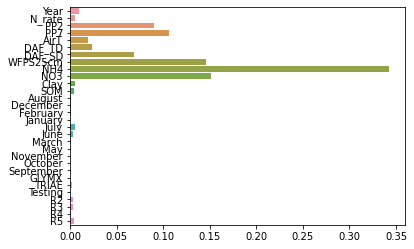

In [ ]:
#hyperparamtre tuning

import optuna

kfolds = KFold(n_splits=5, shuffle=True, random_state=22)

def objective(trial):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", "auto"]),
        "max_samples": trial.suggest_float("max_samples", 0.01, 1),
        "verbose":3
    }
     
    model = RandomForestRegressor(**param)
    
    scores = cross_val_score(model, X, y, cv=kfolds, scoring="r2")
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)       

[I 2021-12-16 17:12:49,554] A new study created in memory with name: no-name-af92dddf-d7e7-457c-9594-f1fc050c57c4
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 345
building tree 2 of 345
building tree 3 of 345
building tree 4 of 345
building tree 5 of 345
building tree 6 of 345
building tree 7 of 345
building tree 8 of 345
building tree 9 of 345
building tree 10 of 345
building tree 11 of 345
building tree 12 of 345
building tree 13 of 345
building tree 14 of 345
building tree 15 of 345
building tree 16 of 345
building tree 17 of 345
building tree 18 of 345
building tree 19 of 345
building tree 20 of 345
building tree 21 of 345
building tree 22 of 345
building tree 23 of 345
building tree 24 of 345
building tree 25 of 345
building tree 26 of 345
building tree 27 of 345
building tree 28 of 345
building tree 29 of 345
building tree 30 of 345
building tree 31 of 345
building tree 32 of 345
building tree 33 of 345
building tree 34 of 345
building tree 35 of 345
building tree 36 of 345
building tree 37 of 345
building tree 38 of 345
building tree 39 of 345
building tree 40 of 345
building tree 41 of 345
building tree 42 of 345
b

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 345
building tree 2 of 345
building tree 3 of 345
building tree 4 of 345
building tree 5 of 345
building tree 6 of 345
building tree 7 of 345
building tree 8 of 345
building tree 9 of 345
building tree 10 of 345
building tree 11 of 345
building tree 12 of 345
building tree 13 of 345
building tree 14 of 345
building tree 15 of 345
building tree 16 of 345
building tree 17 of 345
building tree 18 of 345
building tree 19 of 345
building tree 20 of 345
building tree 21 of 345
building tree 22 of 345
building tree 23 of 345
building tree 24 of 345
building tree 25 of 345
building tree 26 of 345
building tree 27 of 345
building tree 28 of 345
building tree 29 of 345
building tree 30 of 345
building tree 31 of 345
building tree 32 of 345
building tree 33 of 345
building tree 34 of 345
building tree 35 of 345
building tree 36 of 345
building tree 37 of 345
building tree 38 of 345
building tree 39 of 345
building tree 40 of 345
building tree 41 of 345
building tree 42 of 345
b

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 345
building tree 2 of 345
building tree 3 of 345
building tree 4 of 345
building tree 5 of 345
building tree 6 of 345
building tree 7 of 345
building tree 8 of 345
building tree 9 of 345
building tree 10 of 345
building tree 11 of 345
building tree 12 of 345
building tree 13 of 345
building tree 14 of 345
building tree 15 of 345
building tree 16 of 345
building tree 17 of 345
building tree 18 of 345
building tree 19 of 345
building tree 20 of 345
building tree 21 of 345
building tree 22 of 345
building tree 23 of 345
building tree 24 of 345
building tree 25 of 345
building tree 26 of 345
building tree 27 of 345
building tree 28 of 345
building tree 29 of 345
building tree 30 of 345
building tree 31 of 345
building tree 32 of 345
building tree 33 of 345
building tree 34 of 345
building tree 35 of 345
building tree 36 of 345
building tree 37 of 345
building tree 38 of 345
building tree 39 of 345
building tree 40 of 345
building tree 41 of 345
building tree 42 of 345
b

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 345
building tree 2 of 345
building tree 3 of 345
building tree 4 of 345
building tree 5 of 345
building tree 6 of 345
building tree 7 of 345
building tree 8 of 345
building tree 9 of 345
building tree 10 of 345
building tree 11 of 345
building tree 12 of 345
building tree 13 of 345
building tree 14 of 345
building tree 15 of 345
building tree 16 of 345
building tree 17 of 345
building tree 18 of 345
building tree 19 of 345
building tree 20 of 345
building tree 21 of 345
building tree 22 of 345
building tree 23 of 345
building tree 24 of 345
building tree 25 of 345
building tree 26 of 345
building tree 27 of 345
building tree 28 of 345
building tree 29 of 345
building tree 30 of 345
building tree 31 of 345
building tree 32 of 345
building tree 33 of 345
building tree 34 of 345
building tree 35 of 345
building tree 36 of 345
building tree 37 of 345
building tree 38 of 345
building tree 39 of 345
building tree 40 of 345
building tree 41 of 345
building tree 42 of 345
b

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 345
building tree 2 of 345
building tree 3 of 345
building tree 4 of 345
building tree 5 of 345
building tree 6 of 345
building tree 7 of 345
building tree 8 of 345
building tree 9 of 345
building tree 10 of 345
building tree 11 of 345
building tree 12 of 345
building tree 13 of 345
building tree 14 of 345
building tree 15 of 345
building tree 16 of 345
building tree 17 of 345
building tree 18 of 345
building tree 19 of 345
building tree 20 of 345
building tree 21 of 345
building tree 22 of 345
building tree 23 of 345
building tree 24 of 345
building tree 25 of 345
building tree 26 of 345
building tree 27 of 345
building tree 28 of 345
building tree 29 of 345
building tree 30 of 345
building tree 31 of 345
building tree 32 of 345
building tree 33 of 345
building tree 34 of 345
building tree 35 of 345
building tree 36 of 345
building tree 37 of 345
building tree 38 of 345
building tree 39 of 345
building tree 40 of 345
building tree 41 of 345
building tree 42 of 345
b

[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.0s finished
[I 2021-12-16 17:12:55,497] Trial 0 finished with value: 0.13890221184768606 and parameters: {'n_estimators': 345, 'max_depth': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_samples': 0.11313654971401968}. Best is trial 0 with value: 0.13890221184768606.


building tree 316 of 345
building tree 317 of 345
building tree 318 of 345
building tree 319 of 345
building tree 320 of 345
building tree 321 of 345
building tree 322 of 345
building tree 323 of 345
building tree 324 of 345
building tree 325 of 345
building tree 326 of 345
building tree 327 of 345
building tree 328 of 345
building tree 329 of 345
building tree 330 of 345
building tree 331 of 345
building tree 332 of 345
building tree 333 of 345
building tree 334 of 345
building tree 335 of 345
building tree 336 of 345
building tree 337 of 345
building tree 338 of 345
building tree 339 of 345
building tree 340 of 345
building tree 341 of 345
building tree 342 of 345
building tree 343 of 345
building tree 344 of 345
building tree 345 of 345


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 491
building tree 2 of 491
building tree 3 of 491
building tree 4 of 491
building tree 5 of 491
building tree 6 of 491
building tree 7 of 491
building tree 8 of 491
building tree 9 of 491
building tree 10 of 491
building tree 11 of 491
building tree 12 of 491
building tree 13 of 491
building tree 14 of 491
building tree 15 of 491
building tree 16 of 491
building tree 17 of 491
building tree 18 of 491
building tree 19 of 491
building tree 20 of 491
building tree 21 of 491
building tree 22 of 491
building tree 23 of 491
building tree 24 of 491
building tree 25 of 491
building tree 26 of 491
building tree 27 of 491
building tree 28 of 491
building tree 29 of 491
building tree 30 of 491
building tree 31 of 491
building tree 32 of 491
building tree 33 of 491
building tree 34 of 491
building tree 35 of 491
building tree 36 of 491
building tree 37 of 491
building tree 38 of 491
building tree 39 of 491
building tree 40 of 491
building tree 41 of 491
building tree 42 of 491
b

[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 491
building tree 2 of 491
building tree 3 of 491
building tree 4 of 491
building tree 5 of 491
building tree 6 of 491
building tree 7 of 491
building tree 8 of 491
building tree 9 of 491
building tree 10 of 491
building tree 11 of 491
building tree 12 of 491
building tree 13 of 491
building tree 14 of 491
building tree 15 of 491
building tree 16 of 491
building tree 17 of 491
building tree 18 of 491
building tree 19 of 491
building tree 20 of 491
building tree 21 of 491
building tree 22 of 491
building tree 23 of 491
building tree 24 of 491
building tree 25 of 491
building tree 26 of 491
building tree 27 of 491
building tree 28 of 491
building tree 29 of 491
building tree 30 of 491
building tree 31 of 491
building tree 32 of 491
building tree 33 of 491
building tree 34 of 491
building tree 35 of 491
building tree 36 of 491
building tree 37 of 491
building tree 38 of 491
building tree 39 of 491
building tree 40 of 491
building tree 41 of 491
building tree 42 of 491
b

[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 491
building tree 2 of 491
building tree 3 of 491
building tree 4 of 491
building tree 5 of 491
building tree 6 of 491
building tree 7 of 491
building tree 8 of 491
building tree 9 of 491
building tree 10 of 491
building tree 11 of 491
building tree 12 of 491
building tree 13 of 491
building tree 14 of 491
building tree 15 of 491
building tree 16 of 491
building tree 17 of 491
building tree 18 of 491
building tree 19 of 491
building tree 20 of 491
building tree 21 of 491
building tree 22 of 491
building tree 23 of 491
building tree 24 of 491
building tree 25 of 491
building tree 26 of 491
building tree 27 of 491
building tree 28 of 491
building tree 29 of 491
building tree 30 of 491
building tree 31 of 491
building tree 32 of 491
building tree 33 of 491
building tree 34 of 491
building tree 35 of 491
building tree 36 of 491
building tree 37 of 491
building tree 38 of 491
building tree 39 of 491
building tree 40 of 491
building tree 41 of 491
building tree 42 of 491
b

[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 491
building tree 2 of 491
building tree 3 of 491
building tree 4 of 491
building tree 5 of 491
building tree 6 of 491
building tree 7 of 491
building tree 8 of 491
building tree 9 of 491
building tree 10 of 491
building tree 11 of 491
building tree 12 of 491
building tree 13 of 491
building tree 14 of 491
building tree 15 of 491
building tree 16 of 491
building tree 17 of 491
building tree 18 of 491
building tree 19 of 491
building tree 20 of 491
building tree 21 of 491
building tree 22 of 491
building tree 23 of 491
building tree 24 of 491
building tree 25 of 491
building tree 26 of 491
building tree 27 of 491
building tree 28 of 491
building tree 29 of 491
building tree 30 of 491
building tree 31 of 491
building tree 32 of 491
building tree 33 of 491
building tree 34 of 491
building tree 35 of 491
building tree 36 of 491
building tree 37 of 491
building tree 38 of 491
building tree 39 of 491
building tree 40 of 491
building tree 41 of 491
building tree 42 of 491
b

[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 491
building tree 2 of 491
building tree 3 of 491
building tree 4 of 491
building tree 5 of 491
building tree 6 of 491
building tree 7 of 491
building tree 8 of 491
building tree 9 of 491
building tree 10 of 491
building tree 11 of 491
building tree 12 of 491
building tree 13 of 491
building tree 14 of 491
building tree 15 of 491
building tree 16 of 491
building tree 17 of 491
building tree 18 of 491
building tree 19 of 491
building tree 20 of 491
building tree 21 of 491
building tree 22 of 491
building tree 23 of 491
building tree 24 of 491
building tree 25 of 491
building tree 26 of 491
building tree 27 of 491
building tree 28 of 491
building tree 29 of 491
building tree 30 of 491
building tree 31 of 491
building tree 32 of 491
building tree 33 of 491
building tree 34 of 491
building tree 35 of 491
building tree 36 of 491
building tree 37 of 491
building tree 38 of 491
building tree 39 of 491
building tree 40 of 491
building tree 41 of 491
building tree 42 of 491
b

[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 491 out of 491 | elapsed:    0.1s finished
[I 2021-12-16 17:13:02,225] Trial 1 finished with value: 0.3015430725826963 and parameters: {'n_estimators': 491, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.30967681726952806}. Best is trial 1 with value: 0.3015430725826963.


building tree 486 of 491
building tree 487 of 491
building tree 488 of 491
building tree 489 of 491
building tree 490 of 491
building tree 491 of 491


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 471
building tree 2 of 471
building tree 3 of 471
building tree 4 of 471
building tree 5 of 471
building tree 6 of 471
building tree 7 of 471
building tree 8 of 471
building tree 9 of 471
building tree 10 of 471
building tree 11 of 471
building tree 12 of 471
building tree 13 of 471
building tree 14 of 471
building tree 15 of 471
building tree 16 of 471
building tree 17 of 471
building tree 18 of 471
building tree 19 of 471
building tree 20 of 471
building tree 21 of 471
building tree 22 of 471
building tree 23 of 471
building tree 24 of 471
building tree 25 of 471
building tree 26 of 471
building tree 27 of 471
building tree 28 of 471
building tree 29 of 471
building tree 30 of 471
building tree 31 of 471
building tree 32 of 471
building tree 33 of 471
building tree 34 of 471
building tree 35 of 471
building tree 36 of 471
building tree 37 of 471
building tree 38 of 471
building tree 39 of 471
building tree 40 of 471
building tree 41 of 471
building tree 42 of 471
b

[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 471
building tree 2 of 471
building tree 3 of 471
building tree 4 of 471
building tree 5 of 471
building tree 6 of 471
building tree 7 of 471
building tree 8 of 471
building tree 9 of 471
building tree 10 of 471
building tree 11 of 471
building tree 12 of 471
building tree 13 of 471
building tree 14 of 471
building tree 15 of 471
building tree 16 of 471
building tree 17 of 471
building tree 18 of 471
building tree 19 of 471
building tree 20 of 471
building tree 21 of 471
building tree 22 of 471
building tree 23 of 471
building tree 24 of 471
building tree 25 of 471
building tree 26 of 471
building tree 27 of 471
building tree 28 of 471
building tree 29 of 471
building tree 30 of 471
building tree 31 of 471
building tree 32 of 471
building tree 33 of 471
building tree 34 of 471
building tree 35 of 471
building tree 36 of 471
building tree 37 of 471
building tree 38 of 471
building tree 39 of 471
building tree 40 of 471
building tree 41 of 471
building tree 42 of 471
b

[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 471
building tree 2 of 471
building tree 3 of 471
building tree 4 of 471
building tree 5 of 471
building tree 6 of 471
building tree 7 of 471
building tree 8 of 471
building tree 9 of 471
building tree 10 of 471
building tree 11 of 471
building tree 12 of 471
building tree 13 of 471
building tree 14 of 471
building tree 15 of 471
building tree 16 of 471
building tree 17 of 471
building tree 18 of 471
building tree 19 of 471
building tree 20 of 471
building tree 21 of 471
building tree 22 of 471
building tree 23 of 471
building tree 24 of 471
building tree 25 of 471
building tree 26 of 471
building tree 27 of 471
building tree 28 of 471
building tree 29 of 471
building tree 30 of 471
building tree 31 of 471
building tree 32 of 471
building tree 33 of 471
building tree 34 of 471
building tree 35 of 471
building tree 36 of 471
building tree 37 of 471
building tree 38 of 471
building tree 39 of 471
building tree 40 of 471
building tree 41 of 471
building tree 42 of 471
b

[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 471
building tree 2 of 471
building tree 3 of 471
building tree 4 of 471
building tree 5 of 471
building tree 6 of 471
building tree 7 of 471
building tree 8 of 471
building tree 9 of 471
building tree 10 of 471
building tree 11 of 471
building tree 12 of 471
building tree 13 of 471
building tree 14 of 471
building tree 15 of 471
building tree 16 of 471
building tree 17 of 471
building tree 18 of 471
building tree 19 of 471
building tree 20 of 471
building tree 21 of 471
building tree 22 of 471
building tree 23 of 471
building tree 24 of 471
building tree 25 of 471
building tree 26 of 471
building tree 27 of 471
building tree 28 of 471
building tree 29 of 471
building tree 30 of 471
building tree 31 of 471
building tree 32 of 471
building tree 33 of 471
building tree 34 of 471
building tree 35 of 471
building tree 36 of 471
building tree 37 of 471
building tree 38 of 471
building tree 39 of 471
building tree 40 of 471
building tree 41 of 471
building tree 42 of 471
b

[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 471
building tree 2 of 471
building tree 3 of 471
building tree 4 of 471
building tree 5 of 471
building tree 6 of 471
building tree 7 of 471
building tree 8 of 471
building tree 9 of 471
building tree 10 of 471
building tree 11 of 471
building tree 12 of 471
building tree 13 of 471
building tree 14 of 471
building tree 15 of 471
building tree 16 of 471
building tree 17 of 471
building tree 18 of 471
building tree 19 of 471
building tree 20 of 471
building tree 21 of 471
building tree 22 of 471
building tree 23 of 471
building tree 24 of 471
building tree 25 of 471
building tree 26 of 471
building tree 27 of 471
building tree 28 of 471
building tree 29 of 471
building tree 30 of 471
building tree 31 of 471
building tree 32 of 471
building tree 33 of 471
building tree 34 of 471
building tree 35 of 471
building tree 36 of 471
building tree 37 of 471
building tree 38 of 471
building tree 39 of 471
building tree 40 of 471
building tree 41 of 471
building tree 42 of 471
b

[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 471 out of 471 | elapsed:    0.1s finished
[I 2021-12-16 17:13:09,386] Trial 2 finished with value: 0.42349231447023783 and parameters: {'n_estimators': 471, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.937343465779847}. Best is trial 2 with value: 0.42349231447023783.


building tree 429 of 471
building tree 430 of 471
building tree 431 of 471
building tree 432 of 471
building tree 433 of 471
building tree 434 of 471
building tree 435 of 471
building tree 436 of 471
building tree 437 of 471
building tree 438 of 471
building tree 439 of 471
building tree 440 of 471
building tree 441 of 471
building tree 442 of 471
building tree 443 of 471
building tree 444 of 471
building tree 445 of 471
building tree 446 of 471
building tree 447 of 471
building tree 448 of 471
building tree 449 of 471
building tree 450 of 471
building tree 451 of 471
building tree 452 of 471
building tree 453 of 471
building tree 454 of 471
building tree 455 of 471
building tree 456 of 471
building tree 457 of 471
building tree 458 of 471
building tree 459 of 471
building tree 460 of 471
building tree 461 of 471
building tree 462 of 471
building tree 463 of 471
building tree 464 of 471
building tree 465 of 471
building tree 466 of 471
building tree 467 of 471
building tree 468 of 471


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 327
building tree 2 of 327
building tree 3 of 327
building tree 4 of 327
building tree 5 of 327
building tree 6 of 327
building tree 7 of 327
building tree 8 of 327
building tree 9 of 327
building tree 10 of 327
building tree 11 of 327
building tree 12 of 327
building tree 13 of 327
building tree 14 of 327
building tree 15 of 327
building tree 16 of 327
building tree 17 of 327
building tree 18 of 327
building tree 19 of 327
building tree 20 of 327
building tree 21 of 327
building tree 22 of 327
building tree 23 of 327
building tree 24 of 327
building tree 25 of 327
building tree 26 of 327
building tree 27 of 327
building tree 28 of 327
building tree 29 of 327
building tree 30 of 327
building tree 31 of 327
building tree 32 of 327
building tree 33 of 327
building tree 34 of 327
building tree 35 of 327
building tree 36 of 327
building tree 37 of 327
building tree 38 of 327
building tree 39 of 327
building tree 40 of 327
building tree 41 of 327
building tree 42 of 327
b

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 327
building tree 2 of 327
building tree 3 of 327
building tree 4 of 327
building tree 5 of 327
building tree 6 of 327
building tree 7 of 327
building tree 8 of 327
building tree 9 of 327
building tree 10 of 327
building tree 11 of 327
building tree 12 of 327
building tree 13 of 327
building tree 14 of 327
building tree 15 of 327
building tree 16 of 327
building tree 17 of 327
building tree 18 of 327
building tree 19 of 327
building tree 20 of 327
building tree 21 of 327
building tree 22 of 327
building tree 23 of 327
building tree 24 of 327
building tree 25 of 327
building tree 26 of 327
building tree 27 of 327
building tree 28 of 327
building tree 29 of 327
building tree 30 of 327
building tree 31 of 327
building tree 32 of 327
building tree 33 of 327
building tree 34 of 327
building tree 35 of 327
building tree 36 of 327
building tree 37 of 327
building tree 38 of 327
building tree 39 of 327
building tree 40 of 327
building tree 41 of 327
building tree 42 of 327
b

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 327
building tree 2 of 327
building tree 3 of 327
building tree 4 of 327
building tree 5 of 327
building tree 6 of 327
building tree 7 of 327
building tree 8 of 327
building tree 9 of 327
building tree 10 of 327
building tree 11 of 327
building tree 12 of 327
building tree 13 of 327
building tree 14 of 327
building tree 15 of 327
building tree 16 of 327
building tree 17 of 327
building tree 18 of 327
building tree 19 of 327
building tree 20 of 327
building tree 21 of 327
building tree 22 of 327
building tree 23 of 327
building tree 24 of 327
building tree 25 of 327
building tree 26 of 327
building tree 27 of 327
building tree 28 of 327
building tree 29 of 327
building tree 30 of 327
building tree 31 of 327
building tree 32 of 327
building tree 33 of 327
building tree 34 of 327
building tree 35 of 327
building tree 36 of 327
building tree 37 of 327
building tree 38 of 327
building tree 39 of 327
building tree 40 of 327
building tree 41 of 327
building tree 42 of 327
b

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 327
building tree 2 of 327
building tree 3 of 327
building tree 4 of 327
building tree 5 of 327
building tree 6 of 327
building tree 7 of 327
building tree 8 of 327
building tree 9 of 327
building tree 10 of 327
building tree 11 of 327
building tree 12 of 327
building tree 13 of 327
building tree 14 of 327
building tree 15 of 327
building tree 16 of 327
building tree 17 of 327
building tree 18 of 327
building tree 19 of 327
building tree 20 of 327
building tree 21 of 327
building tree 22 of 327
building tree 23 of 327
building tree 24 of 327
building tree 25 of 327
building tree 26 of 327
building tree 27 of 327
building tree 28 of 327
building tree 29 of 327
building tree 30 of 327
building tree 31 of 327
building tree 32 of 327
building tree 33 of 327
building tree 34 of 327
building tree 35 of 327
building tree 36 of 327
building tree 37 of 327
building tree 38 of 327
building tree 39 of 327
building tree 40 of 327
building tree 41 of 327
building tree 42 of 327
b

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 327
building tree 2 of 327
building tree 3 of 327
building tree 4 of 327
building tree 5 of 327
building tree 6 of 327
building tree 7 of 327
building tree 8 of 327
building tree 9 of 327
building tree 10 of 327
building tree 11 of 327
building tree 12 of 327
building tree 13 of 327
building tree 14 of 327
building tree 15 of 327
building tree 16 of 327
building tree 17 of 327
building tree 18 of 327
building tree 19 of 327
building tree 20 of 327
building tree 21 of 327
building tree 22 of 327
building tree 23 of 327
building tree 24 of 327
building tree 25 of 327
building tree 26 of 327
building tree 27 of 327
building tree 28 of 327
building tree 29 of 327
building tree 30 of 327
building tree 31 of 327
building tree 32 of 327
building tree 33 of 327
building tree 34 of 327
building tree 35 of 327
building tree 36 of 327
building tree 37 of 327
building tree 38 of 327
building tree 39 of 327
building tree 40 of 327
building tree 41 of 327
building tree 42 of 327
b

[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:    0.0s finished
[I 2021-12-16 17:13:13,998] Trial 3 finished with value: 0.28305391201522223 and parameters: {'n_estimators': 327, 'max_depth': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_samples': 0.6596593583266265}. Best is trial 2 with value: 0.42349231447023783.


building tree 283 of 327
building tree 284 of 327
building tree 285 of 327
building tree 286 of 327
building tree 287 of 327
building tree 288 of 327
building tree 289 of 327
building tree 290 of 327
building tree 291 of 327
building tree 292 of 327
building tree 293 of 327
building tree 294 of 327
building tree 295 of 327
building tree 296 of 327
building tree 297 of 327
building tree 298 of 327
building tree 299 of 327
building tree 300 of 327
building tree 301 of 327
building tree 302 of 327
building tree 303 of 327
building tree 304 of 327
building tree 305 of 327
building tree 306 of 327
building tree 307 of 327
building tree 308 of 327
building tree 309 of 327
building tree 310 of 327
building tree 311 of 327
building tree 312 of 327
building tree 313 of 327
building tree 314 of 327
building tree 315 of 327
building tree 316 of 327
building tree 317 of 327
building tree 318 of 327
building tree 319 of 327
building tree 320 of 327
building tree 321 of 327
building tree 322 of 327


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 370
building tree 2 of 370
building tree 3 of 370
building tree 4 of 370
building tree 5 of 370
building tree 6 of 370
building tree 7 of 370
building tree 8 of 370
building tree 9 of 370
building tree 10 of 370
building tree 11 of 370
building tree 12 of 370
building tree 13 of 370
building tree 14 of 370
building tree 15 of 370
building tree 16 of 370
building tree 17 of 370
building tree 18 of 370
building tree 19 of 370
building tree 20 of 370
building tree 21 of 370
building tree 22 of 370
building tree 23 of 370
building tree 24 of 370
building tree 25 of 370
building tree 26 of 370
building tree 27 of 370
building tree 28 of 370
building tree 29 of 370
building tree 30 of 370
building tree 31 of 370
building tree 32 of 370
building tree 33 of 370
building tree 34 of 370
building tree 35 of 370
building tree 36 of 370
building tree 37 of 370
building tree 38 of 370
building tree 39 of 370
building tree 40 of 370
building tree 41 of 370
building tree 42 of 370
b

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.0s finished


building tree 1 of 370
building tree 2 of 370
building tree 3 of 370
building tree 4 of 370
building tree 5 of 370
building tree 6 of 370
building tree 7 of 370
building tree 8 of 370
building tree 9 of 370
building tree 10 of 370
building tree 11 of 370
building tree 12 of 370
building tree 13 of 370
building tree 14 of 370
building tree 15 of 370
building tree 16 of 370
building tree 17 of 370
building tree 18 of 370
building tree 19 of 370
building tree 20 of 370
building tree 21 of 370
building tree 22 of 370
building tree 23 of 370
building tree 24 of 370
building tree 25 of 370
building tree 26 of 370
building tree 27 of 370
building tree 28 of 370
building tree 29 of 370
building tree 30 of 370
building tree 31 of 370
building tree 32 of 370
building tree 33 of 370
building tree 34 of 370
building tree 35 of 370
building tree 36 of 370
building tree 37 of 370
building tree 38 of 370
building tree 39 of 370
building tree 40 of 370
building tree 41 of 370
building tree 42 of 370
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 94 of 370
building tree 95 of 370
building tree 96 of 370
building tree 97 of 370
building tree 98 of 370
building tree 99 of 370
building tree 100 of 370
building tree 101 of 370
building tree 102 of 370
building tree 103 of 370
building tree 104 of 370
building tree 105 of 370
building tree 106 of 370
building tree 107 of 370
building tree 108 of 370
building tree 109 of 370
building tree 110 of 370
building tree 111 of 370
building tree 112 of 370
building tree 113 of 370
building tree 114 of 370
building tree 115 of 370
building tree 116 of 370
building tree 117 of 370
building tree 118 of 370
building tree 119 of 370
building tree 120 of 370
building tree 121 of 370
building tree 122 of 370
building tree 123 of 370
building tree 124 of 370
building tree 125 of 370
building tree 126 of 370
building tree 127 of 370
building tree 128 of 370
building tree 129 of 370
building tree 130 of 370
building tree 131 of 370
building tree 132 of 370
building tree 133 of 370
buildi

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 370
building tree 2 of 370
building tree 3 of 370
building tree 4 of 370
building tree 5 of 370
building tree 6 of 370
building tree 7 of 370
building tree 8 of 370
building tree 9 of 370
building tree 10 of 370
building tree 11 of 370
building tree 12 of 370
building tree 13 of 370
building tree 14 of 370
building tree 15 of 370
building tree 16 of 370
building tree 17 of 370
building tree 18 of 370
building tree 19 of 370
building tree 20 of 370
building tree 21 of 370
building tree 22 of 370
building tree 23 of 370
building tree 24 of 370
building tree 25 of 370
building tree 26 of 370
building tree 27 of 370
building tree 28 of 370
building tree 29 of 370
building tree 30 of 370
building tree 31 of 370
building tree 32 of 370
building tree 33 of 370
building tree 34 of 370
building tree 35 of 370
building tree 36 of 370
building tree 37 of 370
building tree 38 of 370
building tree 39 of 370
building tree 40 of 370
building tree 41 of 370
building tree 42 of 370
b

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 370
building tree 2 of 370
building tree 3 of 370
building tree 4 of 370
building tree 5 of 370
building tree 6 of 370
building tree 7 of 370
building tree 8 of 370
building tree 9 of 370
building tree 10 of 370
building tree 11 of 370
building tree 12 of 370
building tree 13 of 370
building tree 14 of 370
building tree 15 of 370
building tree 16 of 370
building tree 17 of 370
building tree 18 of 370
building tree 19 of 370
building tree 20 of 370
building tree 21 of 370
building tree 22 of 370
building tree 23 of 370
building tree 24 of 370
building tree 25 of 370
building tree 26 of 370
building tree 27 of 370
building tree 28 of 370
building tree 29 of 370
building tree 30 of 370
building tree 31 of 370
building tree 32 of 370
building tree 33 of 370
building tree 34 of 370
building tree 35 of 370
building tree 36 of 370
building tree 37 of 370
building tree 38 of 370
building tree 39 of 370
building tree 40 of 370
building tree 41 of 370
building tree 42 of 370
b

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.0s finished


building tree 1 of 370
building tree 2 of 370
building tree 3 of 370
building tree 4 of 370
building tree 5 of 370
building tree 6 of 370
building tree 7 of 370
building tree 8 of 370
building tree 9 of 370
building tree 10 of 370
building tree 11 of 370
building tree 12 of 370
building tree 13 of 370
building tree 14 of 370
building tree 15 of 370
building tree 16 of 370
building tree 17 of 370
building tree 18 of 370
building tree 19 of 370
building tree 20 of 370
building tree 21 of 370
building tree 22 of 370
building tree 23 of 370
building tree 24 of 370
building tree 25 of 370
building tree 26 of 370
building tree 27 of 370
building tree 28 of 370
building tree 29 of 370
building tree 30 of 370
building tree 31 of 370
building tree 32 of 370
building tree 33 of 370
building tree 34 of 370
building tree 35 of 370
building tree 36 of 370
building tree 37 of 370
building tree 38 of 370
building tree 39 of 370
building tree 40 of 370
building tree 41 of 370
building tree 42 of 370
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 92 of 370
building tree 93 of 370
building tree 94 of 370
building tree 95 of 370
building tree 96 of 370
building tree 97 of 370
building tree 98 of 370
building tree 99 of 370
building tree 100 of 370
building tree 101 of 370
building tree 102 of 370
building tree 103 of 370
building tree 104 of 370
building tree 105 of 370
building tree 106 of 370
building tree 107 of 370
building tree 108 of 370
building tree 109 of 370
building tree 110 of 370
building tree 111 of 370
building tree 112 of 370
building tree 113 of 370
building tree 114 of 370
building tree 115 of 370
building tree 116 of 370
building tree 117 of 370
building tree 118 of 370
building tree 119 of 370
building tree 120 of 370
building tree 121 of 370
building tree 122 of 370
building tree 123 of 370
building tree 124 of 370
building tree 125 of 370
building tree 126 of 370
building tree 127 of 370
building tree 128 of 370
building tree 129 of 370
building tree 130 of 370
building tree 131 of 370
building

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:    0.0s finished
[I 2021-12-16 17:13:19,365] Trial 4 finished with value: 0.30960041348479167 and parameters: {'n_estimators': 370, 'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_samples': 0.7007043302113785}. Best is trial 2 with value: 0.42349231447023783.


building tree 367 of 370
building tree 368 of 370
building tree 369 of 370
building tree 370 of 370
Number of finished trials: 5
Best trial: {'n_estimators': 471, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.937343465779847}


0.6724032748720483
MAE: 4.7928255302919425
MSE: 102.56076232973892
RMSE: 10.127228758635747


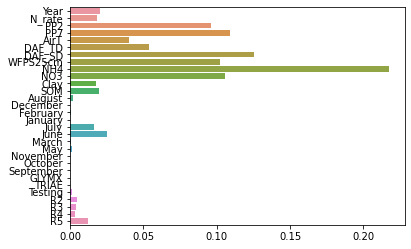

In [ ]:
rf = RandomForestRegressor(**study.best_params)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(r2_score(y_test, y_pred))
sns.barplot(rf.feature_importances_,x_train.columns)#seems like rf preferred continous data over categorical
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
from sklearn.model_selection import KFold

def objective(trial):
    x_train,x_valid,y_train,y_valid=train_test_split(X,y,train_size=0.80,random_state=42)

    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.1,0.2]),
        'n_estimators': trial.suggest_categorical( "n_estimators", [ 300,500,800, 1000]),
        'max_depth': trial.suggest_categorical('max_depth', [4,8,13,17]),
        'random_state': 42
        }
    
    model = XGBRegressor(**param)  
    
    model.fit(x_train,y_train)
    
    preds = model.predict(x_valid)
    
    score = r2_score(y_valid, preds)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)    

[I 2021-12-16 17:17:52,394] A new study created in memory with name: no-name-16866843-e283-48c3-bd27-209e36ab0663


[17:17:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-12-16 17:18:18,027] Trial 0 finished with value: 0.8849044671304779 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 17}. Best is trial 0 with value: 0.8849044671304779.


[17:18:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-12-16 17:18:22,381] Trial 1 finished with value: 0.8482977580927197 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 4}. Best is trial 0 with value: 0.8849044671304779.


[17:18:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-12-16 17:18:26,009] Trial 2 finished with value: 0.8518048629071356 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 8}. Best is trial 0 with value: 0.8849044671304779.


[17:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-12-16 17:18:40,096] Trial 3 finished with value: 0.8619268600496797 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 13}. Best is trial 0 with value: 0.8849044671304779.


[17:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-12-16 17:18:52,326] Trial 4 finished with value: 0.880468294047333 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 17}. Best is trial 0 with value: 0.8849044671304779.


Number of finished trials: 5
Best trial: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 17}


[17:19:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7860738355960304
MAE: 3.7750609307550436
MSE: 66.97390059372162
RMSE: 8.183758341600857


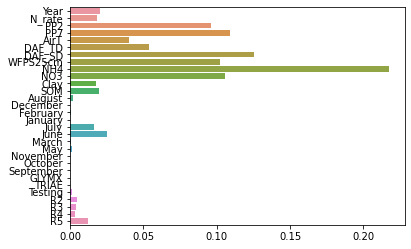

In [ ]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(r2_score(y_test, y_pred))
sns.barplot(rf.feature_importances_,x_train.columns)#seems like rf preferred continous data over categorical
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
def  objective(trial):
    x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=.75,random_state=22)
    
    params = {
       
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_categorical( "n_estimators", [ 300,500,800, 1000]),
        "num_leaves": trial.suggest_int("num_leaves", 6, 64),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'learning_rate': trial.suggest_categorical('learning_rate',[0.01,0.15,0.1])
    }
    lgb=LGBMRegressor(**params)
    lgb.fit(x_train, y_train)
    val_pred = lgb.predict(x_test)
    return r2_score(y_test, val_pred)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-12-16 17:23:41,065] A new study created in memory with name: no-name-f5479305-b836-4bb9-9e32-55329420dc73
[I 2021-12-16 17:23:41,334] Trial 0 finished with value: 0.40985139653323477 and parameters: {'lambda_l1': 0.002370472630071153, 'n_estimators': 300, 'num_leaves': 46, 'feature_fraction': 0.7347294391605097, 'bagging_fraction': 0.6401867353495299, 'bagging_freq': 2, 'learning_rate': 0.1}. Best is trial 0 with value: 0.40985139653323477.
[I 2021-12-16 17:23:42,065] Trial 1 finished with value: 0.3022619322309562 and parameters: {'lambda_l1': 3.8608130185580716e-08, 'n_estimators': 500, 'num_leaves': 38, 'feature_fraction': 0.8751753242491438, 'bagging_fraction': 0.9652408018029071, 'bagging_freq': 5, 'learning_rate': 0.01}. Best is trial 0 with value: 0.40985139653323477.
[I 2021-12-16 17:23:43,184] Trial 2 finished with value: 0.43006727581640847 and parameters: {'lambda_l1': 1.2792700879709777e-07, 'n_estimators': 1000, 'num_leaves': 41, 'feature_fraction': 0.6608127135407

0.6352291093671155
MAE: 4.851886791534885
MSE: 114.19888463291113
RMSE: 10.686387819694321


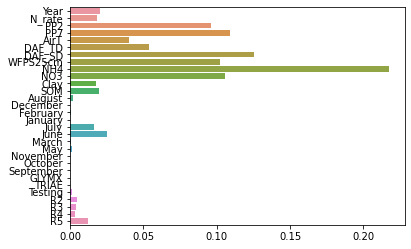

In [ ]:
lgb = LGBMRegressor(**study.best_params)
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_test)
print(r2_score(y_test, y_pred))
sns.barplot(rf.feature_importances_,x_train.columns)#seems like rf preferred continous data over categorical
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [9]:
import joblib


In [11]:
final = pd.read_csv('/content/preprocess.csv')
final.head()

,Year,Experiment,DataUse,Month,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM,N2O
0,2012,3,1,2,170,0.000000,0.000000,-2.0,5.624018,241,0.666508,2.488761,3.175585,63.0,2.0,1.588570
1,2012,3,1,2,170,0.000000,0.000000,-2.4,5.627621,242,0.640608,2.485580,3.176368,63.0,2.0,1.160089
2,2012,3,1,2,170,1.458615,2.265921,0.3,5.655992,250,0.728085,2.470780,3.187258,63.0,2.0,1.513498
3,2012,3,1,2,170,0.000000,2.211566,-3.8,5.659482,251,0.686872,2.472310,3.189323,63.0,2.0,1.468535
4,2012,3,1,3,170,0.703098,2.239645,17.6,5.746203,277,0.716221,2.416338,3.227116,63.0,2.0,1.373153


In [15]:
model = joblib.load('/content/catboost.pkl.compressed')

In [18]:
np.exp(model.predict([2012,3,1,2,170,0,0,-2,5.624,241,0.666,2.48,3.17,63,2]))

4.003255874027523

In [30]:
final[['N2O', 'PP2', 'PP7', 'DAF_TD', 'NH4', 'NO3']].describe()

,N2O,PP2,PP7,DAF_TD,NH4,NO3
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.376314,1.030097,2.383038,4.896544,2.316085,2.943304
std,0.962609,1.200866,1.295900,1.018166,0.616602,0.831534
min,0.000000,0.000000,0.000000,2.071164,0.868525,0.908211
25%,0.646065,0.000000,1.572774,4.276666,1.876137,2.385712
50%,1.209251,0.412110,2.616666,5.081404,2.327353,3.091153
75%,1.923835,1.994700,3.382694,5.747001,2.658299,3.370712
max,3.840489,4.566949,5.564865,6.577861,3.831543,4.848213


In [33]:
final['N_rate'].value_counts()

170    921
0      192
202    166
135    120
157    117
167     69
90      66
213     56
67      56
86      50
91      42
147     38
87      36
162     32
56      21
134     18
Name: N_rate, dtype: int64